# Data Mining Final Project - Yelp Full Review Classification

### Group 16 Team Members:
1. Akanksha Shah (UIN - 136005001)
2. Arvinder Singh Mundra (UIN - 335007465)
3. Kyren Liu (UIN - 830004917)
4. Tasfin Mahmud (UIN - 437004953)

<br>

**Website Link** - https://arvindermundra1208.github.io/yelp-sentiment-analysis/

### Project Goal

The goal of this project is to develop and evaluate deep learning models for predicting Yelp review star ratings (0–4) using only the review text. Specifically, we implement and compare two architectures, a standard Bidirection Long Short-Term Memory (LSTM) network and a hybrid CNN + BiLSTM model, to understand how sequential recurrent models differ from convolution-enhanced sequence models in capturing local patterns, contextual information, and semantic structure in user reviews. Both models are trained and tested on the Yelp Review Full dataset, and their performance is assessed using metrics such as accuracy, precision, recall, and F1-score to determine which architecture better handles the complexities of multi-class text classification.

## Imports

In [ ]:
!pip install optuna datasets wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers
from collections import Counter
import optuna
import math
import torch.optim as optim
from copy import deepcopy
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import spacy
from sklearn.linear_model import LogisticRegression
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, mean_absolute_error


## Loading Dataset

In [ ]:
dataset = load_dataset("yelp_review_full")
df_train = dataset["train"].to_pandas()
df_test  = dataset["test"].to_pandas()
df_train.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [ ]:
print("Shape of training data: ", df_train.shape)
print("Shape of testing data: ", df_test.shape)

Shape of training data:  (650000, 2)
Shape of testing data:  (50000, 2)




The Yelp Full Review dataset contains user generated restaurant and business reviews collected from the Yelp, and labelled with a star rating from 0 to 4.

**Dataset Composition:**

1. Total training samples: 650,000
2. Total testing samples: 50,000
3. Total samples: 700,000
4. Labels 0(worst) --> 4(best)
5. Features:
   1. `text` :  The raw review text written by Yelp user
   2. `label` :  The corresponding star label


Each review varies in length, writing style, sentiment intensity, and linguistic complexity, making the dataset well-suited for evaluating deep learning models on sentiment classification, natural language understanding, and sequence modeling tasks.




## Data Preprocessing

This section outlines the preprocessing pipeline applied to the raw review data. Same pre-processing is applied to training and testing dataset.

### Eliminating Invalid Rows

Before preprocessing, the dataset was cleaned to remove entries with missing or invalid text data. Rows where the review text was either NULL, empty, or contained only whitespace were eliminated to ensure that only meaningful, non-empty reviews were passed to the preprocessing and training stages.

In [ ]:
# Train dataset
df_train = df_train.dropna(subset=['text', 'label'])            #  Drop explicit NaN or None
df_train = df_train[df_train['text'].str.strip().astype(bool)]  #  Drop rows where 'text' is empty or only whitespace

# Test dataset
df_test = df_test.dropna(subset=['text', 'label'])
df_test = df_test[df_test['text'].str.strip().astype(bool)]

In [ ]:
print("Shape of training data: ", df_train.shape)
print("Shape of testing data: ", df_test.shape)

Shape of training data:  (650000, 2)
Shape of testing data:  (50000, 2)


### Text Normalization
To ensure consistency and prepare the text for modeling, several text normalization steps were applied to the review data. At a high level, the process involved:

1. Converting all text to lowercase for consistency.

2. Removing escape characters, newlines, and extra spaces.

3. Replacing URLs and emoticons with generic tokens.

4. Simplifying repeated punctuation and standardizing ellipses.

5. Preserving contractions and hyphenated words.

6. Adding uniform spacing around punctuation for clean tokenization.

7. Normalizing whitespaces.


In [ ]:
def preprocess_review(review):

  if not isinstance(review, str):
    return ""

  # Lowercase
  review = review.lower()

  # Normalize newlines and escaped quotes
  review = review.replace('\\n', ' ').replace('\n', ' ').replace('\\r', ' ').replace('\r', ' ')
  review = re.sub(r'\\"', ' ', review)
  review = re.sub(r"\\'", ' ', review)
  review = re.sub(r'\\', ' ', review)

  # Eliminate URLs
  review = re.sub(r'http\S+|www\.\S+|https\S+', ' <URL> ', review)

  # Positive emoticons: :) :-) :D =D ;D
  pos_emoticons = r'(:\)|:-\)|:\]|:D|:-D|=D|;D|;\)|:p|:-p|:P|:-P|xD|XD)'
  review = re.sub(pos_emoticons, ' <POS_EMOTICON> ', review)

  # Negative emoticons: :( :-( :/ :-/ :\ :-\
  neg_emoticons = r'(:\(|:-\(|:/|:-/|:\\|:-\\|:\[|:{|>:\()'
  review = re.sub(neg_emoticons, ' <NEG_EMOTICON> ', review)

  # Normalize punctuation patterns
  review = re.sub(r'-{2,}', ' - ', review)
  review = re.sub(r'\.{3,}', '<ELLIPSIS>', review)
  review = re.sub(r'([!?.,;:])\1+', r'\1', review)
  review = re.sub(r'(\?\!|\!\?|\?\!\?|\!\?\!)', ' ?! ', review)

  # Spacing around punctuations
  punctuation_to_space = string.punctuation.replace("'", "").replace("-", "").replace("<", "").replace(">", "").replace("_", "").replace("%", "").replace("+", "")
  review = re.sub(r'([%s])' % re.escape(punctuation_to_space), r' \1 ', review)

  review = review.replace('<ELLIPSIS>', ' ... ')

  # Normalize whitespaces
  review = re.sub(r'\s+', ' ', review).strip()

  return review

In [ ]:
df_train['cleaned_text'] = df_train['text'].apply(preprocess_review)
df_test['cleaned_text'] = df_test['text'].apply(preprocess_review)

## Exploratory Data Analysis

In [ ]:
df_train.describe()

,label
count,650000.000000
mean,2.000000
std,1.414215
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,4.000000


### Rating Distribution

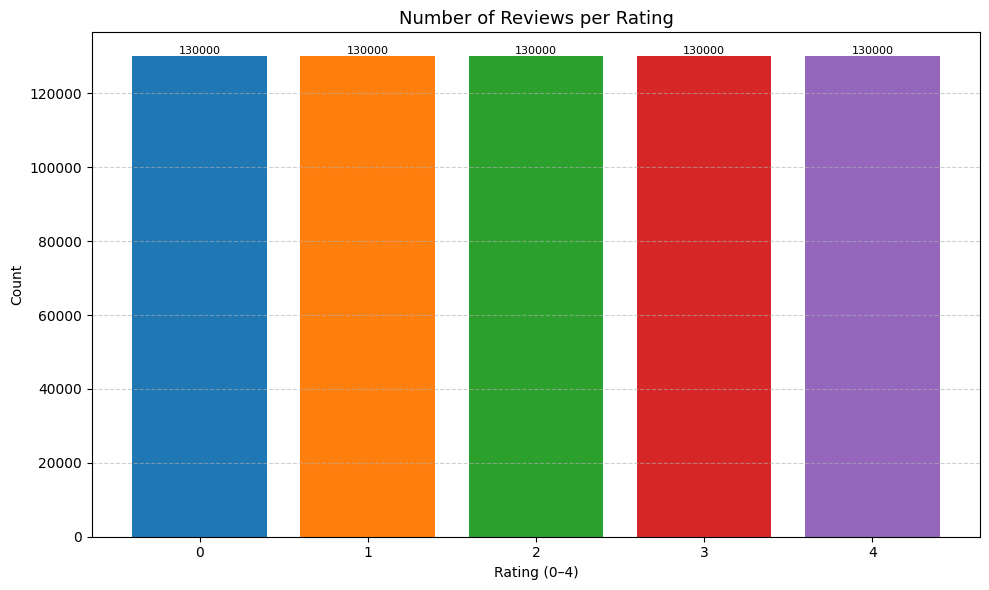

In [ ]:
rating_counts = df_train['label'].value_counts().sort_index()

plt.figure(figsize=(10,6))

for i, (label, count) in enumerate(rating_counts.items()):
    plt.bar(str(label), count)
    plt.text(i, count, str(count), ha="center", va="bottom", fontsize=8)

plt.title("Number of Reviews per Rating", fontsize=13)
plt.xlabel("Rating (0–4)")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

The bar chart illustrates the distribution of reviews across the five rating classes (0–4). Each rating category contains exactly 130,000 reviews, showing that the dataset is perfectly balanced, with each class contributing 20% of the total data.

This balanced distribution eliminates concerns about class imbalance, ensuring that models trained on this dataset will not be biased toward any particular rating.

### Review Length Distribution

In [ ]:
df_train["review_len"] = df_train["cleaned_text"].apply(lambda x: len(str(x).split()))
length_stats = df_train["review_len"].describe()

print("Descriptive statistics for review lengths (in words):\n")
print(length_stats)

p90 = np.percentile(df_train["review_len"], 90)
p95 = np.percentile(df_train["review_len"], 95)
p99 = np.percentile(df_train["review_len"], 99)

print(f"90th percentile: {p90}")
print(f"95th percentile: {p95}")
print(f"99th percentile: {p99}")

Descriptive statistics for review lengths (in words):

count    650000.000000
mean        152.969620
std         138.283057
min           1.000000
25%          60.000000
50%         113.000000
75%         200.000000
max        1178.000000
Name: review_len, dtype: float64
90th percentile: 322.0
95th percentile: 422.0
99th percentile: 684.0


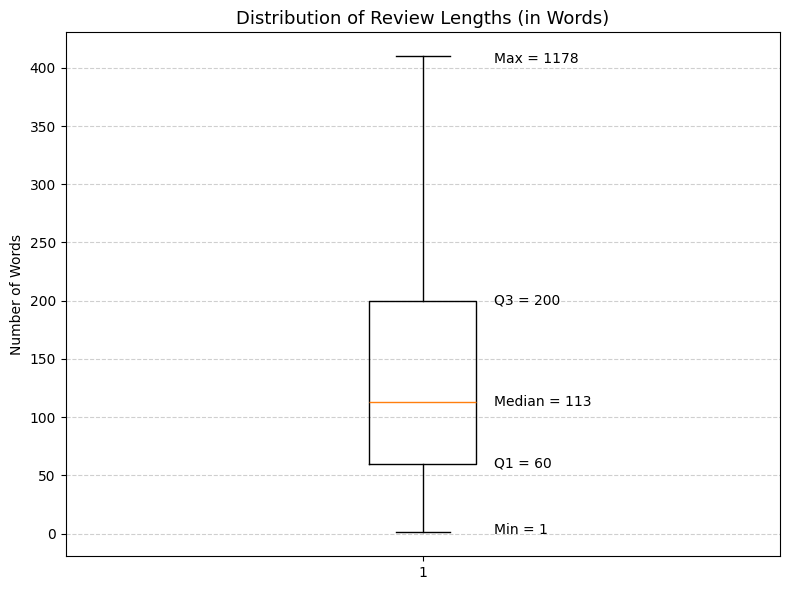

In [ ]:
plt.figure(figsize=(8,6))
plt.boxplot(df_train["review_len"], vert=True, showfliers=False)
plt.title("Distribution of Review Lengths (in Words)", fontsize=13)
plt.ylabel("Number of Words")
plt.grid(axis="y", linestyle="--", alpha=0.6)

minimum = length_stats["min"]
q1 = length_stats["25%"]
median = length_stats["50%"]
q3 = length_stats["75%"]
maximum = length_stats["max"]

plt.text(1.1, q1,     f"Q1 = {int(q1)}", va="center")
plt.text(1.1, median, f"Median = {int(median)}", va="center")
plt.text(1.1, q3,     f"Q3 = {int(q3)}", va="center")

ymin, ymax = plt.ylim()
plt.text(1.1, ymin + (ymax-ymin)*0.05, f"Min = {int(minimum)}", va="center")
plt.text(1.1, ymax - (ymax-ymin)*0.05, f"Max = {int(maximum)}", va="center")

plt.tight_layout()
plt.show()



The boxplot of review lengths (measured in number of words) reveals a highly right-skewed distribution, indicating that while most Yelp reviews are relatively short, a small fraction are exceptionally long. This skewness is also reflected in the descriptive statistics: although the mean review length is 153 words, the median is much lower at 113 words, showing that a few very long reviews pull the average upward. The standard deviation of 138 words further highlights the substantial variability in review lengths.

The first quartile (Q1 = 60 words), median (113 words), and third quartile (Q3 = 200 words) produce an interquartile range (IQR) of about 140 words, meaning that the central 50% of reviews fall within a fairly compact range. However, percentile analysis shows how the right tail expands sharply: the 90th percentile is 322 words, the 95th is 422 words, and the 99th percentile reaches 684 words. The absolute minimum review length is 1 word, while the maximum extends to 1,178 words, confirming the presence of high-end outliers representing highly detailed, narrative-style reviews.

Overall, while most reviews cluster between 60–200 words, the existence of very long reviews creates a long-tailed distribution. This characteristic is important for downstream modeling, as padding/truncation strategies must account for widely varying sequence lengths without introducing excessive computational overhead. The clear right skew would be helpful in deciding the maximum sequence length for tokenization and model input pipelines.

### Review Length Distribution Per Rating

In [ ]:
ratings = sorted(df_train["label"].unique())

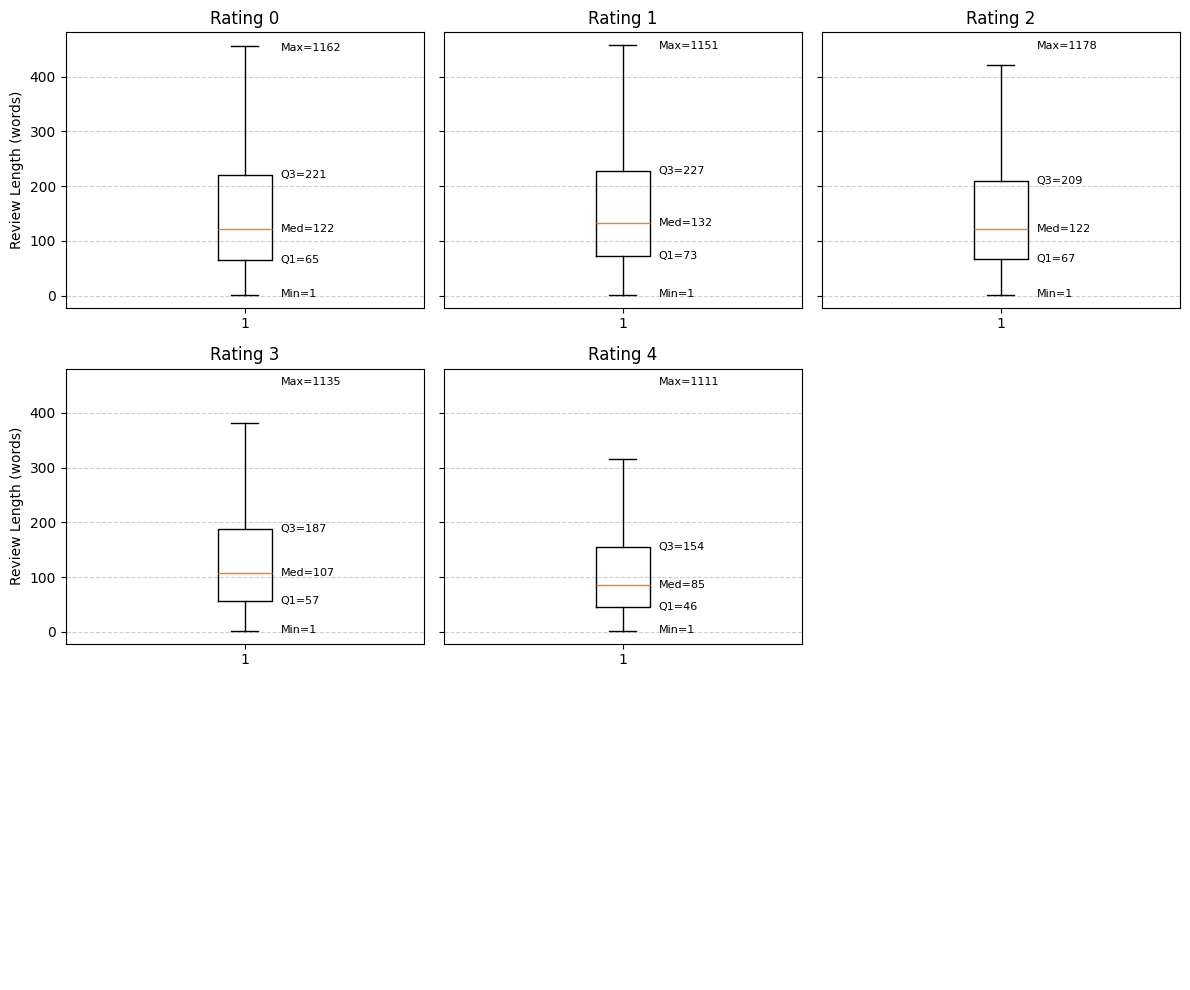

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharey=True)

axes = axes.flatten()

for idx, rating in enumerate(ratings):

    # extract data for the rating
    data = df_train[df_train["label"] == rating]["review_len"]

    # boxplot
    axes[idx].boxplot(data, vert=True, showfliers=False)
    axes[idx].set_title(f"Rating {rating}")
    axes[idx].grid(axis="y", linestyle="--", alpha=0.6)
    if idx in [0, 3]:
      axes[idx].set_ylabel("Review Length (words)")

    # compute quartiles
    q1 = np.percentile(data, 25)
    median = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    minimum = np.percentile(data, 0)
    maximum = np.percentile(data, 100)

    ymin, ymax = axes[idx].get_ylim()

    # annotate quartiles & min/max
    axes[idx].text(1.1, q1,     f"Q1={int(q1)}", va="center", fontsize=8)
    axes[idx].text(1.1, median, f"Med={int(median)}", va="center", fontsize=8)
    axes[idx].text(1.1, q3,     f"Q3={int(q3)}", va="center", fontsize=8)
    axes[idx].text(1.1, ymin + 0.05*(ymax-ymin), f"Min={int(minimum)}", va="center", fontsize=8)
    axes[idx].text(1.1, ymax - 0.05*(ymax-ymin), f"Max={int(maximum)}", va="center", fontsize=8)

for j in range(len(ratings), len(axes)):
    axes[j].axis("off")


plt.tight_layout()
plt.show()


Building on the overall review-length distribution, we further examine how review length varies by rating using five separate boxplots. A clear pattern is observed: lower-rated reviews (0, 1, 2) tend to be longer and more variable, while higher-rated reviews (3 and 4) are shorter and more consistent.

For ratings 0, 1, and 2, the median review lengths fall between 122–132 words. Q1 ranges from 65–73 words, and Q3 spans 209–227 words, resulting in wide IQRs of approximately 144–154 words, indicating substantial spread. In contrast, ratings 3 and 4 show noticeably reduced lengths, with medians of 107 words and 85 words, respectively, and smaller IQRs.

Despite these differences, all rating levels share similar minimum and maximum values: the minimum remains 1 word, and maximum lengths exceed 1100 words across every class, confirming the presence of extremely long outliers in all categories.

Overall, this comparison reinforces that negative and neutral reviews are generally longer and more detailed, whereas positive reviews are shorter and more concise, which is consistent with typical user-review behavior.

### Top Frequency Sentiment Bearing Words

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

counter = Counter()

for doc in nlp.pipe(df_train["cleaned_text"].head(5000), batch_size=500):
    for token in doc:
        if token.is_alpha and not token.is_stop and token.pos_ in {"ADJ"}:
            counter[token.lemma_.lower()] += 1

top25 = counter.most_common(25)

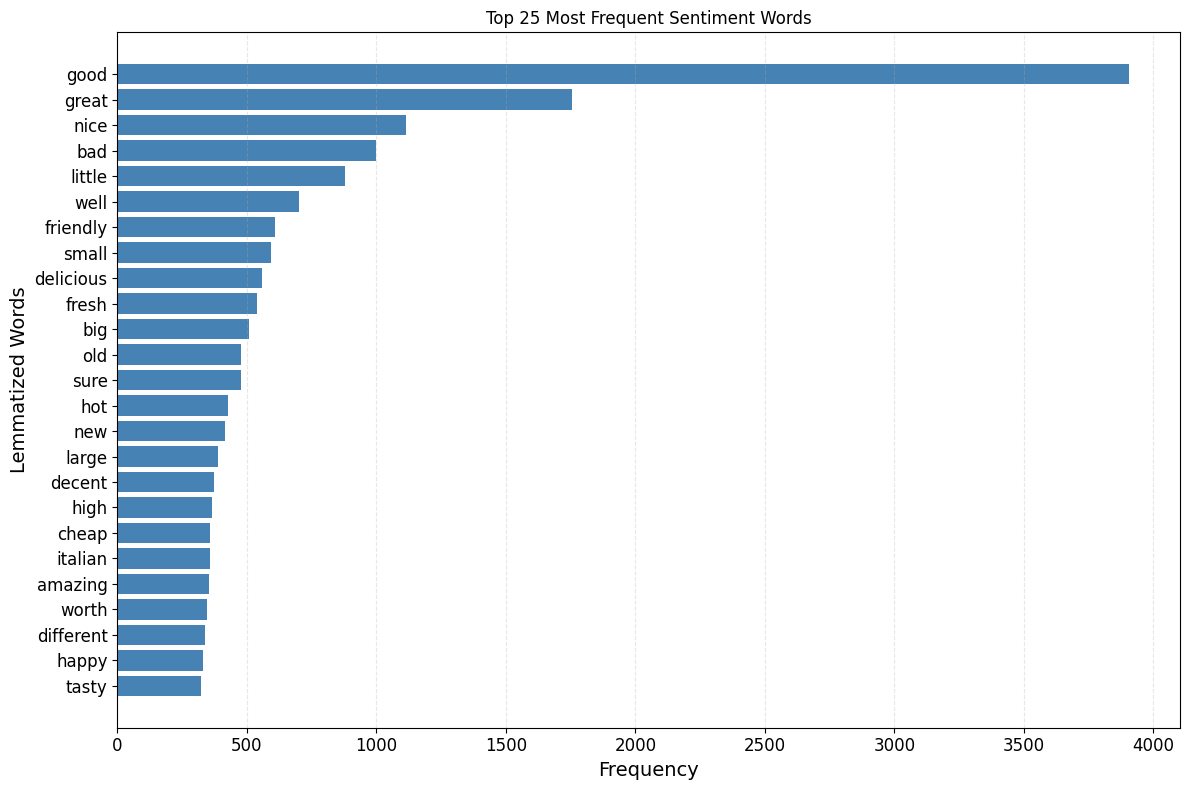

In [ ]:
words = [w for w, c in top25]
counts = [c for w, c in top25]

plt.figure(figsize=(12, 8))
plt.barh(words[::-1], counts[::-1], color="steelblue")
plt.title("Top 25 Most Frequent Sentiment Words")
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Lemmatized Words", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Continuing from the review-length analysis, we next examine the most frequent sentiment-bearing words in the dataset. The top 25 lemmatized words show a clear dominance of positive descriptors such as "good," "great," "nice," "well," "friendly," "delicious," and "fresh." Negative terms like "bad" or "cheap" do appear, but far less frequently.

This pattern aligns with earlier observations: positive reviews are more common and tend to use brief, straightforward positive language, while negative reviews, though longer and more detailed, contribute fewer high-frequency negative words overall.

Overall, the sentiment-word distribution reinforces a positively skewed vocabulary across the Yelp Review Full dataset.

### Sentiment Analysis Per Rating

Sentiment analysis per rating is performed by training a Logistic Regression classifier on TF-IDF representations of the cleaned review text. After the model learns the weight contributions of each word toward predicting a specific rating, we extract the top 200 most influential words for each rating class. These high-impact words are then visualized using word clouds, giving an intuitive view of the strongest lexical signals associated with each rating level. This helps us understand how the model internally distinguishes between negative, neutral, and positive reviews based on their vocabulary.

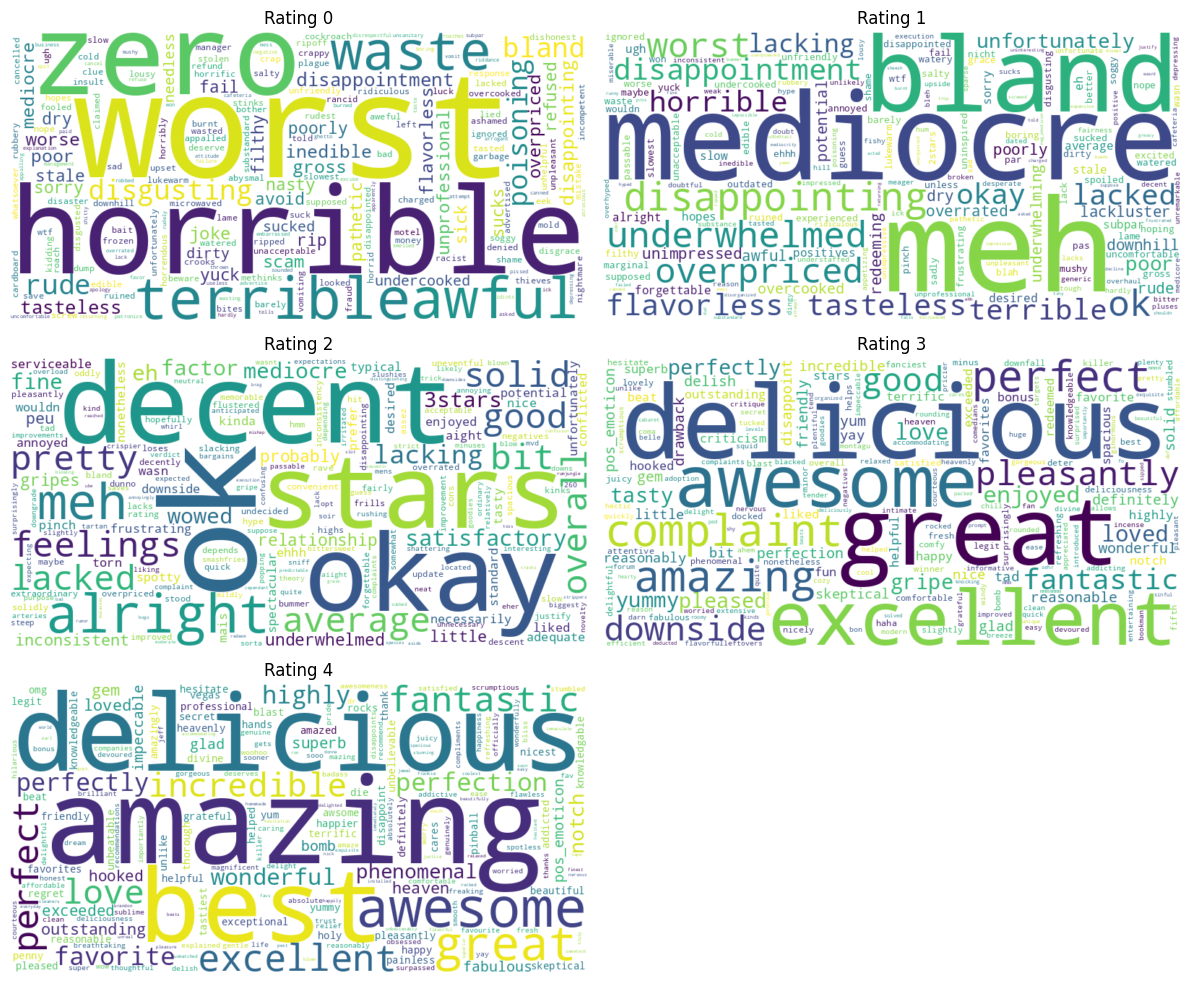

In [ ]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=30000,
    min_df=5
)

# TF-IDF
X = tfidf.fit_transform(df_train["cleaned_text"].astype(str))
y = df_train["label"].values
vocab = np.array(tfidf.get_feature_names_out())

# Logistic Regression
clf = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

clf.fit(X, y)

coefs = clf.coef_
classes = clf.classes_

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

top_n = 200

# Word Cloud
for i, rating in enumerate(classes):
    weights = coefs[i]
    top_idx = np.argsort(weights)[::-1][:top_n]
    freqs = {vocab[j]: float(weights[j]) for j in top_idx}

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=top_n
    ).generate_from_frequencies(freqs)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Rating {rating}", fontsize=12)

axes[-1].axis("off")

plt.tight_layout()
plt.show()


For rating 0, the most prominent words are strongly negative-"horrible," "worst," "zero," "disgusting", reflecting the highly critical tone typical of very negative reviews.
For rating 1, the vocabulary remains negative but less severe, with terms like "bland," "meh," "mediocre," and "underwhelmed," showing a shift toward milder dissatisfaction.
At rating 2, the cloud is dominated by neutral expressions such as "okay," "average," "decent," indicating a transition point where reviews are neither strongly positive nor strongly negative.
For ratings 3 and 4, the sentiment becomes clearly positive, with frequent terms like "perfect," , "excellent," "delicious," "great," "amazing," ,"best", and "awesome." These words represent strong approval and align with the shorter, more positive review patterns observed earlier.

Overall, the word clouds demonstrate a monotonic relationship between rating score and sentiment polarity: vocabulary shifts smoothly from harshly negative -> mildly negative -> neutral ->  positive --> strongly positive as the rating increases. This confirms that each rating level exhibits a distinctive and meaningful lexical profile, reinforcing the sentiment patterns identified throughout the EDA.

### POS Tagging

The grammatical structure of reviews is analyzed by performing Part-of-Speech (POS) tagging on the first 5,000 cleaned samples. Using spaCy, we extract only key POS categories-nouns, verbs, adjectives, and adverbs, and count how often each appears within every rating level. These counts are then organized into a DataFrame and normalized to compare POS usage patterns across ratings. This step allows us to investigate whether different rating levels exhibit distinct linguistic tendencies and whether negative, neutral, and positive reviews differ in their grammatical composition.

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "lemmatizer"])
allowed_pos = {"NOUN", "VERB", "ADV", "ADJ"}
pos_by_rating = defaultdict(Counter)

# First 5000 cleaned samples
df_sample = df_train[["cleaned_text", "label"]].head(5000)

texts = df_sample["cleaned_text"].tolist()
labels = df_sample["label"].to_numpy()


for doc, rating in zip(nlp.pipe(texts, batch_size=64, n_process=2),labels):
    counter = pos_by_rating[rating]
    for token in doc:

        if not token.is_alpha:
            continue

        pos = token.pos_

        if pos in allowed_pos:
            counter[pos] += 1

# Build counts per rating
pos_rating_df = (
    pd.DataFrame.from_dict(pos_by_rating, orient="index")
      .fillna(0)
      .astype(int)
      .sort_index()
)

# Row-normalized proportions
pos_rating_prop = pos_rating_df.div(pos_rating_df.sum(axis=1), axis=0)

print(pos_rating_prop)

       VERB       ADJ      NOUN       ADV
0  0.278732  0.160963  0.406209  0.154095
1  0.241638  0.183645  0.413816  0.160902
2  0.217097  0.199909  0.428932  0.154062
3  0.207984  0.207707  0.433906  0.150403
4  0.219940  0.201486  0.428675  0.149900


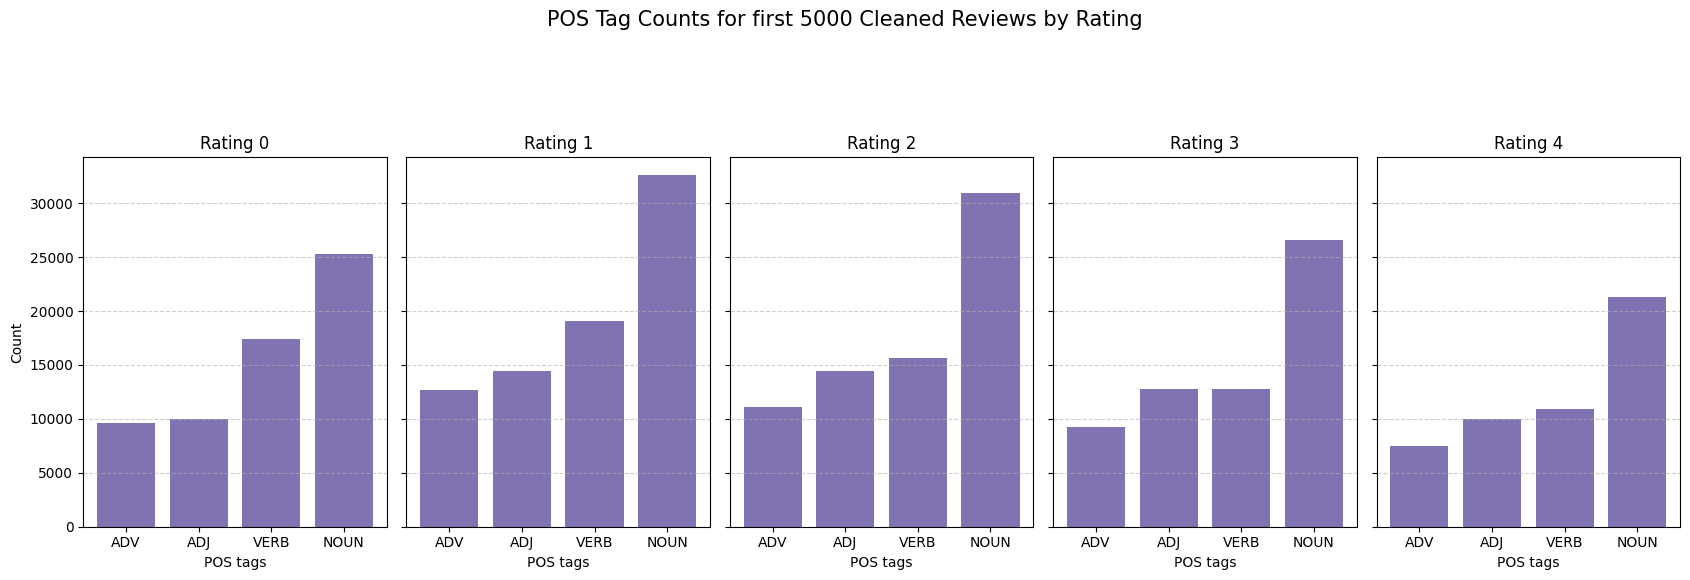

In [ ]:
ratings = sorted(pos_rating_prop.index)
fig, axes = plt.subplots(1, len(ratings), figsize=(17, 5), sharey=True)
axes = axes.flatten()
for idx, rating in enumerate(ratings):

    pos_series_rating = pos_rating_df.loc[rating].sort_values(ascending=True)
    axes[idx].bar(pos_series_rating.index, pos_series_rating.values, color="#8172B2")
    axes[idx].set_title(f"Rating {rating}", fontsize=12)
    axes[idx].set_xlabel("POS tags")
    axes[idx].grid(axis="y", linestyle="--", alpha=0.6)
    if idx == 0:
        axes[idx].set_ylabel("Count")

plt.suptitle("POS Tag Counts for first 5000 Cleaned Reviews by Rating", fontsize = 15, y=1.15)
plt.tight_layout()
plt.show()

All five ratings follow the same structural pattern, with nouns appearing most frequently, followed by verbs, then adjectives, and finally adverbs. Notably, adverbs remain consistently the least used across all rating levels, indicating that reviewers, regardless of sentiment, tend to rely less on intensifiers or stylistic modifiers and focus more on factual or descriptive wording. The differences across ratings occur mainly in the total number of tokens rather than in the ordering of tags. Ratings 1 and 2 show the highest overall POS counts, reflecting that slightly negative and neutral reviews tend to be longer and contain more linguistic content. Rating 0 also has substantial POS counts but remains slightly lower than ratings 1 and 2. In contrast, ratings 3 and 4 exhibit lower counts across all POS categories, consistent with the earlier finding that positive reviews are typically shorter and more concise. Overall, the POS-tag distributions across ratings highlight that while the linguistic structure remains similar, review length drives the variation, with lower and mid-range ratings producing more POS tokens and higher ratings remaining brief and to the point.

### Dimensionality Reduction



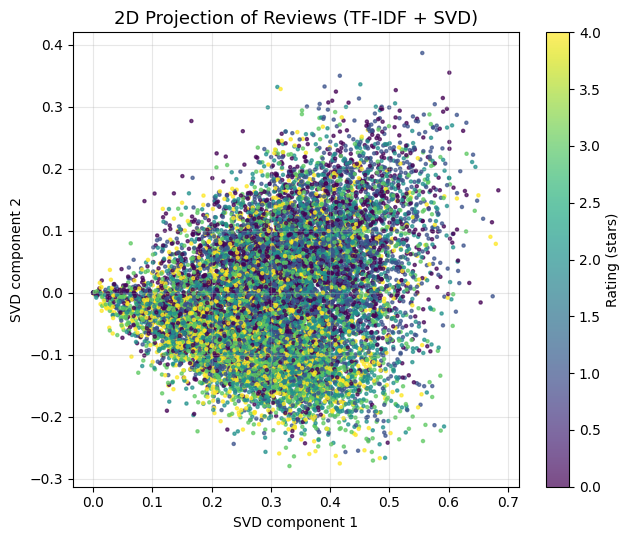

In [ ]:
df_vis = df_train.head(15000).copy()

# TF-IDF Representation
tfidf = TfidfVectorizer(max_features=6000)
X = tfidf.fit_transform(df_vis["cleaned_text"])

# SVD Dimensionality Reduction
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X)

# Plot
fig, ax = plt.subplots(figsize=(6.5,5.5))
scatter = ax.scatter(X_2d[:,0], X_2d[:,1],
                     c=df_vis["label"],
                     cmap="viridis",
                     s=5,
                     alpha=0.7)

ax.set_title("2D Projection of Reviews (TF-IDF + SVD)", fontsize=13)
ax.set_xlabel("SVD component 1")
ax.set_ylabel("SVD component 2")

ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Rating (stars)")
plt.tight_layout()
plt.show()


Using TF-IDF followed by a 2-component Truncated SVD, we projected 15,000 reviews into a 2-dimensional space to visualize how textual content varies across rating levels. The scatter plot shows a dense, overlapping cluster of points, indicating that reviews from different ratings do not form clearly separable groups in this reduced space. Although there is a slight gradient, where some higher-rated reviews appear more toward the right side of the projection, the separation is weak, and the colors (representing ratings 0–4) are heavily intermixed throughout the plot.

This suggests that the raw lexical features captured by TF-IDF alone do not provide enough structure for clear class boundaries when compressed into two dimensions. The review text is high-dimensional and sentiment-rich, but its distinctions across ratings become difficult to visualize when reduced to only two components. This also implies that models must rely on richer representations (e.g., embeddings, neural architectures) rather than expecting simple linear separation in low-dimensional space.

Overall, the SVD projection confirms that ratings are not easily separable using basic TF-IDF features, reinforcing the need for deeper models or more expressive feature representations for accurate classification.

## Train/Validation Split

We divide the original training data into a new training subset (80%) and a validation set (20%). The 80% subset is used for fitting the model, while the 20% validation set is held aside for hyperparameter tuning and monitoring model performance during training.

Stratification is performed during train/valdiation split by review labels to ensure that both the sets have a balanced distribution of 0-to-4 star ratings. The held-out test set remains untouched until final evaluation.






In [ ]:
df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df_train['label']
)

print("Shape of training data: ", df_train.shape)
print("Shape of validation data: ", df_val.shape)
print("Shape of testing data: ", df_test.shape)

Shape of training data:  (520000, 4)
Shape of validation data:  (130000, 4)
Shape of testing data:  (50000, 3)


## Building Vocab

To prepare the text for sequence modelling, a word-level vocabulary is first constructed from the training dataset. This vocabulary maps each unique word to a corresponding integer index, transforming raw text into numerical sequences that can be processed by the LSTM-based architecture.

Restricting the vocabulary to the most frequent terms serves two purposes: it reduces the dimensionality of the input space, thereby controlling model complexity, and ensures that the retained words are the most informative for sentiment prediction.

A minimum frequency threshold of 5 occurrences is applied to filter out rare or noisy tokens, and the overall vocabulary size is capped at 20,000 words to maintain computational efficiency. Additionally, special tokens such as `<PAD>` and `<UNK>` are incorporated to support sequence padding and the handling of out-of-vocabulary words. This vocabulary forms the backbone of the processing pipeline and is used consistently throughout all downstream modeling components.  

In [ ]:
def build_vocab_with_tokenizers(df,vocab_size,min_freq,text_col):

    # Generator that yields lists of tokens (pre-tokenized)
    def token_iterator():
        for text in df[text_col]:
            yield text.split()

    # Initialize WordLevel tokenizer
    tokenizer = Tokenizer(models.WordLevel(unk_token="<UNK>"))

    special_tokens = ["<PAD>", "<UNK>"]

    trainer = trainers.WordLevelTrainer(
        vocab_size=vocab_size,
        min_frequency=min_freq,
        special_tokens=special_tokens,
    )

    # Train from the streaming iterator
    tokenizer.train_from_iterator(token_iterator(), trainer)

    # Get vocab: token -> id
    word_to_int = tokenizer.get_vocab()

    print("Vocab size:", len(word_to_int))
    print("ID of <PAD>:", word_to_int.get("<PAD>"))
    print("ID of <UNK>:", word_to_int.get("<UNK>"))

    return word_to_int, tokenizer

df_train_word_to_int, df_train_tokenizer = build_vocab_with_tokenizers(df_train, 20000, 5, "cleaned_text")

Vocab size: 20000
ID of <PAD>: 0
ID of <UNK>: 1


## Encoding and Padding Sequences


To prepare the data for LSTM-based modeling, each review is first tokenized and transformed into a sequence of integer IDs using the previously constructed vocabulary. Because neural networks operate on fixed-length inputs, all sequences are either padded or truncated to a consistent maximum length.

An exploratory analysis of review length distributions showed that approximately 99% of Yelp reviews contain fewer than 700 tokens; therefore, we set `MAX_LEN = 650` to capture the vast majority of meaningful content while maintaining computational efficiency.

A custom collate function is employed within the data loader to handle tokenization, padding, and batch assembly dynamically at runtime. This ensures that the model receives uniformly structured, numerically encoded sequences during both training and evaluation.


In [ ]:
# Max sequence length
MAX_LEN = 650
pad_id = df_train_word_to_int["<PAD>"]

# Truncation
df_train_tokenizer.enable_truncation(MAX_LEN)

# Padding
df_train_tokenizer.enable_padding(
    length=MAX_LEN,
    pad_id=pad_id,
    pad_token="<PAD>",
    direction="right",
)

# Collate function
def make_collate_fn(tokenizer):

    def collate_fn(batch):
        texts  = [x[0] for x in batch]
        labels = torch.tensor([x[1] for x in batch], dtype=torch.long)

        # Tokenization
        token_lists = [t.split() for t in texts]

        # Encoding
        encodings = tokenizer.encode_batch(token_lists, is_pretokenized=True)

        input_ids = torch.tensor([enc.ids for enc in encodings], dtype=torch.long)

        return input_ids, labels

    return collate_fn

train_collate_fn = make_collate_fn(df_train_tokenizer)
val_collate_fn   = make_collate_fn(df_train_tokenizer)
test_collate_fn  = make_collate_fn(df_train_tokenizer)

## Pytorch Dataset

The preprocessed text and their corresponding labels are wrapped into a PyTorch Dataset to enable efficient batching and loading during training. This structure is used consistently across the training, validation, and testing splits.

In [ ]:
class YelpTextDataset(Dataset):

    def __init__(self, df, text_col="cleaned_text", label_col="label"):

        # preprocessed text strings
        self.texts = df[text_col].tolist()

        # integer labels
        self.labels = df[label_col].tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [ ]:
# Train PyTorch dataset
train_dataset = YelpTextDataset(df_train, text_col="cleaned_text", label_col="label")

# Validation PyTorch dataset
val_dataset   = YelpTextDataset(df_val,   text_col="cleaned_text", label_col="label")

# Test PyTorch dataset
test_dataset  = YelpTextDataset(df_test,  text_col="cleaned_text", label_col="label")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Helpers

### Training and Validation

To optimize the model, a custom train_validate() function is used to perform full-epoch training while simultaneously evaluating model performance on a separate validation set. During each epoch, the model is trained over all batches in the training loader using cross-entropy loss and the Adam optimizer, with losses and accuracies accumulated across the epoch. The validation set is then processed in evaluation mode to obtain an unbiased estimate of generalization quality.

Although the model is trained for all epochs to enable visualization of training and validation loss curves (useful for identifying overfitting), the function additionally tracks the best validation loss encountered during training. Whenever a new minimum validation loss is observed, a deep copy of the model’s state is saved. After all epochs are completed, these best-performing weights are restored, ensuring that the final returned model corresponds to its strongest generalization performance rather than its final (potentially overfitted) state. The function also returns epoch-wise loss and accuracy statistics for plotting and analysis.

In [ ]:
def train_validate(model, train_loader, val_loader, learning_rate, weight_decay, no_of_epochs):

  # Loss function
  criterion = nn.CrossEntropyLoss()

  # Adam Optimizer
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  EPOCHS = no_of_epochs

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  best_val_loss = float("inf")
  best_state_dict = None
  best_epoch = -1

  for epoch in range(1, EPOCHS + 1):

      # Training
      model.train()
      total_train_loss = 0.0
      total_train_correct = 0
      total_train_examples = 0

      for batch_x, batch_y in train_loader:
          batch_x = batch_x.to(device)
          batch_y = batch_y.to(device)

          optimizer.zero_grad()
          logits = model(batch_x)
          loss = criterion(logits, batch_y)
          loss.backward()
          optimizer.step()

          total_train_loss += loss.item() * batch_x.size(0)

          preds = logits.argmax(dim=1)
          total_train_correct += (preds == batch_y).sum().item()
          total_train_examples += batch_x.size(0)

      avg_train_loss = total_train_loss / total_train_examples
      train_acc = total_train_correct / total_train_examples

      train_losses.append(avg_train_loss)
      train_accuracies.append(train_acc)

      # Validation
      model.eval()
      total_val_loss = 0.0
      total_val_correct = 0
      total_val_examples = 0

      with torch.no_grad():
          for batch_x, batch_y in val_loader:
              batch_x = batch_x.to(device)
              batch_y = batch_y.to(device)

              logits = model(batch_x)
              loss = criterion(logits, batch_y)

              total_val_loss += loss.item() * batch_x.size(0)

              preds = logits.argmax(dim=1)
              total_val_correct += (preds == batch_y).sum().item()
              total_val_examples += batch_x.size(0)

      avg_val_loss = total_val_loss / total_val_examples
      val_acc = total_val_correct / total_val_examples

      val_losses.append(avg_val_loss)
      val_accuracies.append(val_acc)

      print(
          f"Epoch {epoch}/{EPOCHS} | "
          f"train_loss={avg_train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={avg_val_loss:.4f}, val_acc={val_acc:.4f}"
      )


      # Track best model
      if avg_val_loss < best_val_loss:

          best_val_loss = avg_val_loss
          best_epoch = epoch

          # Deep copy of weights
          best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}


  # Restore best model weights
  if best_state_dict is not None:
      model.load_state_dict(best_state_dict)

  print(f"\nBest epoch: {best_epoch} with val_loss={best_val_loss:.4f}")

  return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def plot_train_validation_loss(train_losses, val_losses, model_name):

    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, marker='o', label="Training Loss")
    plt.plot(epochs, val_losses, marker='o', label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training vs Validation Loss - {model_name} Model")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.xticks(epochs)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Model Testing

To evaluate the model’s generalization performance on unseen data, a dedicated evaluate_on_test() function is used. The model is first placed in evaluation mode to disable dropout and other training-specific behaviors. The function iterates over all batches in the test dataloader without tracking gradients, ensuring efficient and unbiased inference.

For each batch, the model produces output logits, which are converted into predicted class labels using argmax. These predictions, along with the true labels, are collected for later computation of evaluation metrics such as confusion matrices and classification reports. The overall test accuracy is computed by comparing predicted and true labels across all batches. The function returns the final test accuracy along with complete lists of predictions and ground-truth labels for further analysis and visualization.

In [ ]:
def evaluate_on_test(model, test_loader):
    model.eval()
    preds_list = []
    labels_list = []

    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            preds = logits.argmax(dim=1)

            preds_list.extend(preds.cpu().tolist())
            labels_list.extend(batch_y.cpu().tolist())

            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

    accuracy = correct / total
    return accuracy, preds_list, labels_list

### Model Evaluation

This section provides helper methods to analyze model performance on the test set. A confusion matrix is first computed from the predicted and true labels, summarizing how frequently each rating is correctly or incorrectly classified. A heatmap visualizes this matrix to highlight common misclassification patterns. Additional helper functions extract class-wise counts (TP, FP, FN, TN) and compute key metrics such as precision, recall, F1-score, specificity, and per-class accuracy. These metrics offer a detailed, interpretable performance of the model across all Yelp rating categories.

In [ ]:

# Confusion Matrix Helpers

def get_confusion_matrix(test_labels, test_preds):
    y_true = np.array(test_labels)
    y_pred = np.array(test_preds)
    cm = confusion_matrix(y_true, y_pred)
    return cm


# Heatmap Visualization

def visualize_cm(cm, model_name):
    plt.figure(figsize=(10,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name} model")
    plt.xlabel("Predicted Rating")
    plt.ylabel("True Rating")
    plt.tight_layout()
    plt.show()


# Metric Computation

def safe_div(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    out = np.zeros_like(a, dtype=float)
    mask = b != 0
    out[mask] = a[mask] / b[mask]
    return out


def get_metric_counts_from_confusion_matrix(cm):
    cm = np.array(cm)
    TP = np.diag(cm).astype(int)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)
    support = TP + FN
    K = cm.shape[0]

    index = [f"Rating {i}" for i in range(K)]

    counts_df = pd.DataFrame({
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN,
        "Support": support
    }, index=index)

    return counts_df


def get_metrics_from_confusion_matrix(cm, counts_df):

    TP = counts_df["TP"].values
    FP = counts_df["FP"].values
    FN = counts_df["FN"].values
    TN = counts_df["TN"].values
    support = counts_df["Support"].values

    precision   = safe_div(TP, TP + FP)
    recall      = safe_div(TP, TP + FN)
    f1          = safe_div(2 * precision * recall, precision + recall)
    specificity = safe_div(TN, TN + FP)
    accuracy    = safe_div(TP + TN, TP + TN + FP + FN)

    index = [f"Rating {i}" for i in range(len(TP))]

    metrics_df = pd.DataFrame({
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Specificity": specificity,
        "Accuracy Per Class": accuracy,
        "Support": support
    }, index=index).round(4)

    return metrics_df


### Model Inference

This function enables single-review prediction using the trained model. A raw input review is first passed through the same preprocessing pipeline used during training to ensure consistent text normalization. The cleaned review is then tokenized using the project’s custom tokenizer, and the resulting token IDs are converted into a PyTorch tensor suitable for model input. With gradient computation disabled, the model performs a forward pass to generate logits, and the predicted rating is obtained by selecting the class with the highest score. The function returns the final predicted rating, allowing the model to be used interactively for new, unseen Yelp reviews.

In [ ]:
def predict_rating(model, tokenizer, review, device):
    model.eval()

    # Preprocess review
    text = preprocess_review(review)

    # Tokenize review
    token_list = review.split()
    encoding = tokenizer.encode(token_list, is_pretokenized=True)

    # Convert to tensor
    input_ids = torch.tensor(encoding.ids, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_ids)
        pred_class = logits.argmax(dim=1).item()

    return pred_class

## LSTM Model Implementation

### Model Selection

We chose an LSTM model because our task involves text sequences. Customer reviews are written as sentences, and the meaning depends on the order of words. A simple neural network cannot understand this order, but an LSTM can. It can remember important words that appear earlier in the review and use them to interpret later words. For example, the sentence “The food was good, but the service was terrible” changes meaning at the word “but”. An LSTM can capture this shift because it processes the text step by step.

Another reason for choosing LSTM is that it can handle long reviews. Yelp reviews often contain many sentences. Traditional RNNs forget earlier information, but LSTMs use a gating mechanism to preserve important details for a longer time.

- It handles sequential text naturally.
- It remembers long-range patterns.
- It works well for sentiment and review classification tasks.
- It is simple to implement and serves as a strong baseline model.




### LSTM Model

The LSTM model begins with an embedding layer that converts token IDs into dense vector representations learned during training. These embeddings are then passed through a multi-layer bidirectional LSTM, allowing the network to capture contextual information from both past and future words in the sequence. From the final hidden states of the LSTM, we apply dropout for regularization and feed the resulting representation into a linear classification layer that outputs probabilities over the five rating classes.

In [ ]:
class LSTMClassifier(nn.Module):

    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx, num_layers = 1, bidirectional = True, dropout = 0.5):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout if num_layers > 1 else 0.0)
        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_out_dim, num_classes)

    def forward(self, input_ids):

        # Embeddings
        embedded = self.embedding(input_ids)

        output, (h_n, c_n) = self.lstm(embedded)

        if self.lstm.bidirectional:
            h_last = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_last = h_n[-1]

        # Drop out regularization
        x = self.dropout(h_last)

        # Linear classification layer
        logits = self.fc(x)

        return logits


### Model Parameter Hypertuning

Optuna is used to automatically search for the best LSTM hyperparameters by sampling different settings for embedding size, hidden dimension, number of layers, dropout, learning rate, weight decay, and batch size. For each trial, a model is instantiated with the sampled configuration and trained for a small number of epochs, with validation accuracy used as the optimization objective. A learning-rate scheduler and gradient clipping are applied to stabilize training, while Optuna’s pruning mechanism stops poorly performing trials early. The best validation accuracy achieved in each trial is returned, allowing Optuna to identify the most effective hyperparameter combination across all trials.

In [ ]:
def objective(trial, no_of_epochs=3):
    # Search Space
    embed_dim    = trial.suggest_categorical("embed_dim",    [64, 128, 256])
    hidden_dim   = trial.suggest_categorical("hidden_dim",   [64, 128, 256])
    num_layers   = trial.suggest_categorical("num_layers",   [1, 2])
    dropout      = trial.suggest_categorical("dropout",      [0.1, 0.2, 0.3, 0.5])
    lr           = trial.suggest_categorical("lr",           [5e-4, 1e-3, 2e-3])
    weight_decay = trial.suggest_categorical("weight_decay", [0.0, 1e-5, 1e-4])
    batch_size   = trial.suggest_categorical("batch_size",   [32, 64, 128])

    # Train DataLoader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=train_collate_fn,
        num_workers=2,
        pin_memory=True,
    )

    # Validation DataLoader
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=val_collate_fn,
        num_workers=2,
        pin_memory=True,
    )

    # Model
    model = LSTMClassifier(
        vocab_size=len(df_train_word_to_int),
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        num_classes=df_train["label"].nunique(),
        pad_idx=df_train_word_to_int["<PAD>"],
        num_layers=num_layers,
        bidirectional=True,
        dropout=dropout,
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=1
    )

    EPOCHS = no_of_epochs

    best_val_loss = float("inf")
    best_epoch_metrics = {
        "epoch": None,
        "train_loss": None,
        "train_acc": None,
        "val_loss": None,
        "val_acc": None,
    }

    for ep in range(1, EPOCHS + 1):

        # Training Loop
        model.train()
        tl, tc, n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            tl += loss.item() * xb.size(0)
            tc += (logits.argmax(1) == yb).sum().item()
            n  += xb.size(0)

        train_loss = tl / n
        train_acc  = tc / n

        # Validation Loop
        model.eval()
        vl, vc, vn = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                vl += loss.item() * xb.size(0)
                vc += (logits.argmax(1) == yb).sum().item()
                vn += xb.size(0)

        val_loss = vl / vn
        val_acc  = vc / vn

        # Step scheduler on validation loss
        scheduler.step(val_loss)

        # Report validation loss to Optuna
        trial.report(val_loss, step=ep)

        # Pruning based on the intermediate loss
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Track best (lowest) val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_metrics = {
                "epoch": ep,
                "train_loss": float(train_loss),
                "train_acc": float(train_acc),
                "val_loss": float(val_loss),
                "val_acc": float(val_acc),
            }

    print(f"\n==== Trial {trial.number} ====")
    print("Params:", trial.params)
    print(
        f"Best epoch: {best_epoch_metrics['epoch']} | "
        f"Train Loss: {best_epoch_metrics['train_loss']:.4f}, "
        f"Train Acc:  {best_epoch_metrics['train_acc']:.4f}, "
        f"Val Loss:   {best_epoch_metrics['val_loss']:.4f}, "
        f"Val Acc:    {best_epoch_metrics['val_acc']:.4f}"
    )
    print("====================================\n")

    return best_val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5, timeout=None)

print("Best trial val_loss:", study.best_trial.value)
print("Best params:", study.best_trial.params)

### Best Model

After completing the Optuna search, the best-performing hyperparameter configuration is retrieved from the study and used to instantiate a new LSTM model. This step ensures that the final model is constructed with the optimal choices for embedding dimension, hidden size, number of layers, and dropout probability identified during tuning. The resulting model serves as the fully optimized architecture that is then trained (or fine-tuned) on the complete training pipeline for final evaluation.

In [ ]:
best = study.best_trial.params
best_model = LSTMClassifier(
    vocab_size=len(df_train_word_to_int),
    embed_dim=best["embed_dim"],
    hidden_dim=best["hidden_dim"],
    num_classes=df_train["label"].nunique(),
    pad_idx=df_train_word_to_int["<PAD>"],
    num_layers=best["num_layers"],
    bidirectional=True,
    dropout=best["dropout"],
).to(device)

#### Model Training and Validation

>

In [ ]:
BEST_BATCH_SIZE = best["batch_size"]

# Training Dataset
best_train_loader = DataLoader(
    train_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=True,
    collate_fn=train_collate_fn,
)

# Validation Dataset
best_val_loader = DataLoader(
    val_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=False,
    collate_fn=val_collate_fn,
)

# Test Dataset
best_test_loader = DataLoader(
    test_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=False,
    collate_fn=test_collate_fn,
)

# Sanity check
batch_x, batch_y = next(iter(best_train_loader))
print(batch_x.shape)
print(batch_y.shape)

best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_validate (best_model, best_train_loader, best_val_loader, best["lr"], best["weight_decay"], 8)

torch.Size([64, 650])
torch.Size([64])


#### Training and Validation Loss

In [ ]:
plot_train_validation_loss(train_losses, val_losses, "BiLSTM")

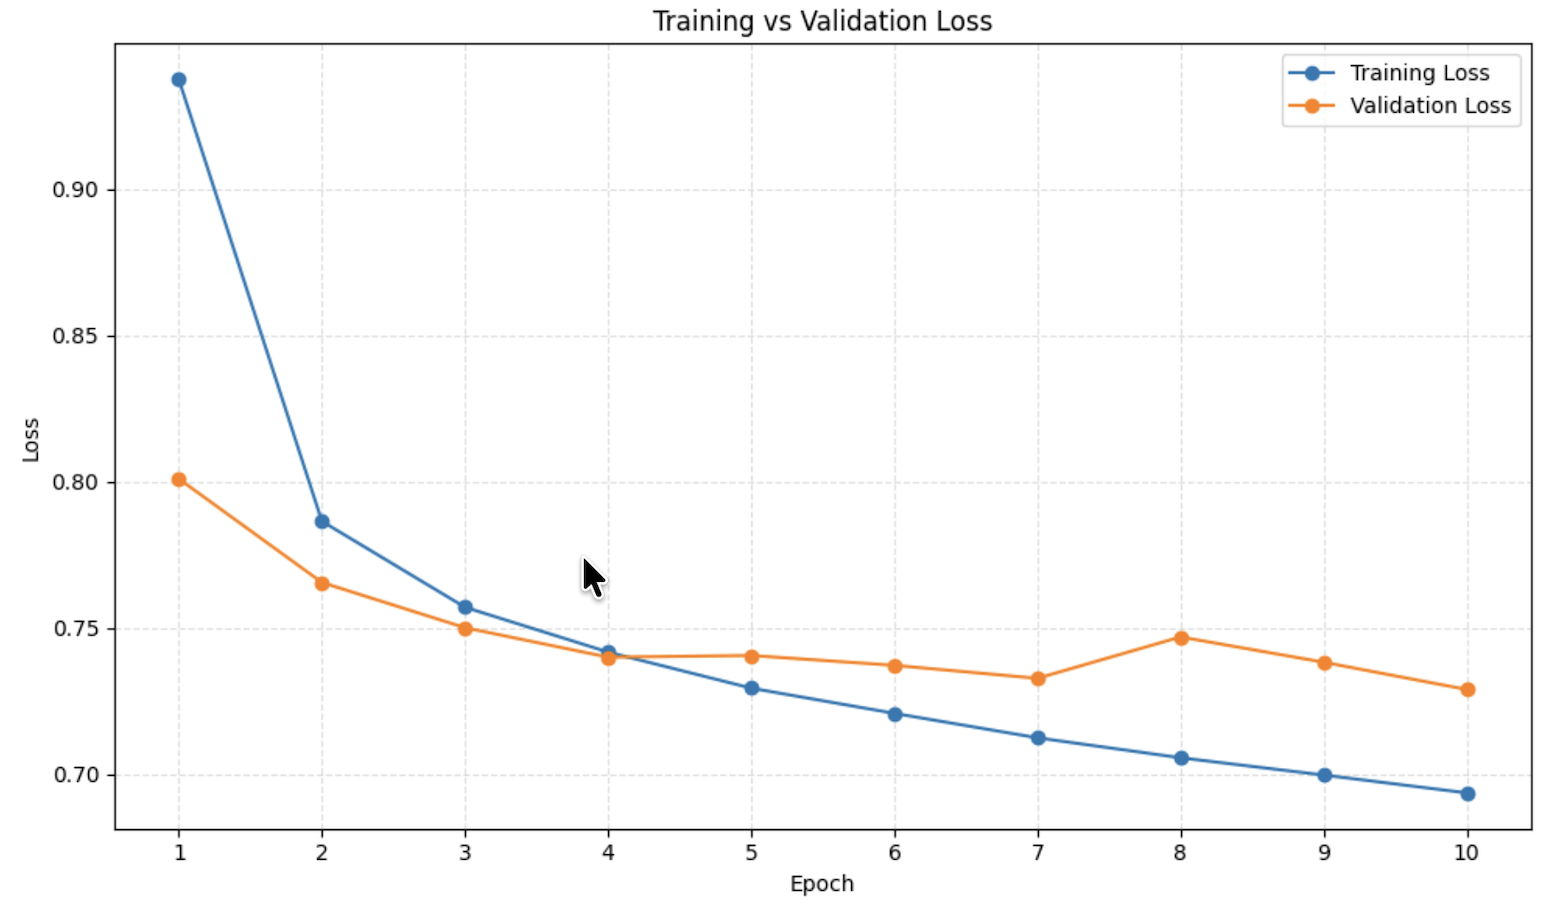

The above graph demonstrates the training v/s validaton loss plot for BiLSTM model. The model is trained on the best hypertuned parameters:
1. Embedding Dimension: 128
2. Hidden Dimension: 64
3. Number of LSTM Layers: 2
4. Dropout Rate: 0.2
5. Learning Rate: 2x10^-3
6. Weight Decay: 1x10^-5
7. Batch Size: 64

The heighest validation accuracy of 0.6748 was obtained at epoch 10 with corresponding training accuracy of 0.6714.

The training and validation loss curves show a steady downward trend, reflecting stable learning throughout the training process. The validation loss closely follows the training loss, with only minor fluctuations, indicating that the model generalizes well and does not suffer from overfitting.

#### Save Best Model

In [ ]:
best_model = LSTMClassifier(
    vocab_size=len(df_train_word_to_int),
    embed_dim=128,
    hidden_dim=64,
    num_classes=df_train["label"].nunique(),
    pad_idx=df_train_word_to_int["<PAD>"],
    num_layers=2,
    bidirectional=True,
    dropout=0.2,
).to(device)

In [ ]:
SAVE_PATH = "best_lstm_yelp_model.pth"

torch.save({
    "model_state_dict": best_model.state_dict(),
    "vocab": df_train_word_to_int,                  # save vocabulary
    "tokenizer_json": df_train_tokenizer.to_str(),  # save tokenizer config
    "params": best                                  # hyperparameters
}, SAVE_PATH)

print("Model saved to:", SAVE_PATH)

Model saved to: best_lstm_yelp_model.pth


#### Model Testing

##### Load the saved model

In [ ]:
checkpoint = torch.load("best_lstm_yelp_model.pth")

best_model.load_state_dict(checkpoint["model_state_dict"])
best_model.eval()

LSTMClassifier(
  (embedding): Embedding(20000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

##### Model Testing

Upon completing training with the optimal hyperparameters, the finalized model is evaluated on the reserved test set to obtain an unbiased estimate of its predictive performance. Because the test data is not used at any stage of model training or hyperparameter tuning, this evaluation provides a rigorous measure of the model’s ability to generalize to unseen Yelp reviews. The resulting test accuracy reflects the model’s real-world effectiveness and serves as the principal metric for assessing its overall performance compared to baseline methods and alternative architectures.



In [ ]:
test_acc, test_preds, test_labels = evaluate_on_test(best_model, best_test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6762


#### Performance Metrics

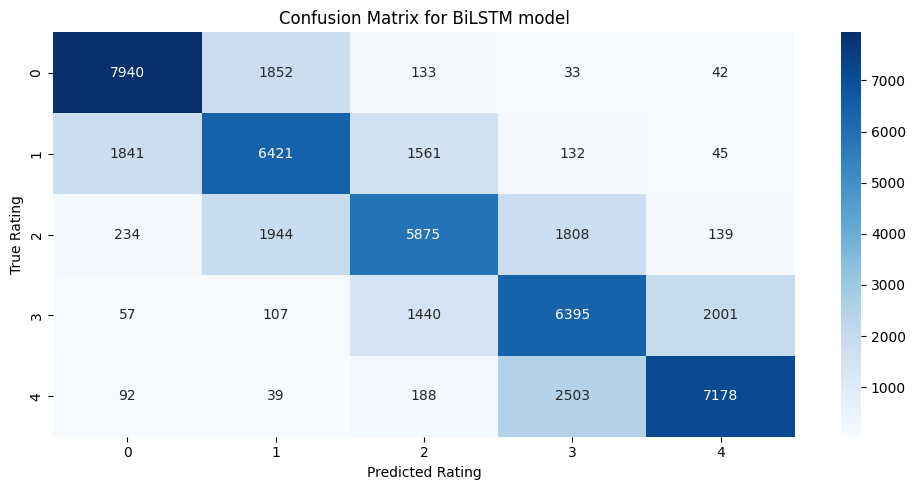

In [ ]:
# Confusion Matrix
cm = get_confusion_matrix(test_labels, test_preds)
visualize_cm(cm, "BiLSTM")

In [ ]:
# F1, Recall, Precision and Per-class Accuracy
counts_df = get_metric_counts_from_confusion_matrix(cm)
get_metrics_from_confusion_matrix(cm, counts_df)

,Precision,Recall,F1,Specificity,Accuracy Per Class,Support
Rating 0,0.7812,0.7940,0.7875,0.9444,0.9143,10000
Rating 1,0.6196,0.6421,0.6307,0.9014,0.8496,10000
Rating 2,0.6388,0.5875,0.6121,0.9170,0.8511,10000
Rating 3,0.5883,0.6395,0.6128,0.8881,0.8384,10000
Rating 4,0.7632,0.7178,0.7398,0.9443,0.8990,10000


##### Analysis of Misclassified Examples

In [ ]:
# After cleaning df_test
df_test = df_test.reset_index(drop=True)

In [ ]:
results_df = pd.DataFrame({
    "true_label": test_labels,
    "pred_label": test_preds,
})

results_df["cleaned_text"] = df_test["cleaned_text"].values[:len(results_df)]
results_df["review_len"] = df_test["cleaned_text"].str.split().str.len().values[:len(results_df)]

# error and absolute error
results_df["error"] = results_df["pred_label"] - results_df["true_label"]
results_df["abs_error"] = results_df["error"].abs()

# flag misclassified
results_df["correct"] = (results_df["true_label"] == results_df["pred_label"])

# quick summary
total = len(results_df)
mis = (~results_df["correct"]).sum()
print(f"Total test samples: {total}")
print(f"Misclassified: {mis} ({mis/total:.2%})")

print("\nAbsolute error distribution:")
print(results_df["abs_error"].value_counts().sort_index())

Total test samples: 50000
Misclassified: 16191 (32.38%)

Absolute error distribution:
abs_error
0    33809
1    14950
2      933
3      174
4      134
Name: count, dtype: int64


In [ ]:
def bucket_length(n):
    if n < 60:
        return "short (<60)"
    elif n <= 200:
        return "medium (60-200)"
    else:
        return "long (>200)"

results_df["len_bucket"] = results_df["review_len"].apply(bucket_length)

# misclassification rate by bucket
bucket_stats = (
    results_df
    .groupby("len_bucket")["correct"]
    .agg(["count", lambda x: (~x).sum()])
    .rename(columns={"<lambda_0>": "num_errors"})
)

bucket_stats["error_rate"] = bucket_stats["num_errors"] / bucket_stats["count"]
print(bucket_stats)

                 count  num_errors  error_rate
len_bucket                                    
long (>200)      12487        3704    0.296628
medium (60-200)  25220        8106    0.321412
short (<60)      12293        4381    0.356382


In [ ]:
mis_df = results_df[~results_df["correct"]]

# how many are off by 1 vs >=2
off1 = (mis_df["abs_error"] == 1).sum()
off2plus = (mis_df["abs_error"] >= 2).sum()

print(f"Off by 1 star: {off1} ({off1/mis:.2%} of misclassifications)")
print(f"Off by >=2 stars: {off2plus} ({off2plus/mis:.2%} of misclassifications)")

Off by 1 star: 14950 (92.34% of misclassifications)
Off by >=2 stars: 1241 (7.66% of misclassifications)


In [ ]:
def show_examples(df, true_label, pred_label, n=5):
    subset = df[(df["true_label"] == true_label) &
                (df["pred_label"] == pred_label)]
    print(f"\n=== True {true_label} → Pred {pred_label} "
          f"(showing up to {n} of {len(subset)}) ===\n")
    for i, (_, row) in enumerate(subset.head(n).iterrows(), 1):
        print(f"Example {i} (length={row['review_len']} words):")
        print(row["cleaned_text"])
        print("-" * 80)

# Examples of common confusions
show_examples(mis_df, 2, 3)  # neutral → slightly positive
show_examples(mis_df, 3, 4)  # good → excellent
show_examples(mis_df, 1, 0)  # slightly negative → very negative
show_examples(mis_df, 3, 1)  # mixed error two steps away


=== True 2 → Pred 3 (showing up to 5 of 1808) ===

Example 1 (length=19 words):
great barnes and noble location , and they have plenty of books that'll help you pass the time .
--------------------------------------------------------------------------------
Example 2 (length=71 words):
stopped here for drinks before we went on to dinner elsewhere . in hindsight , we wish we had stayed here . <POS_EMOTICON> we had a couple of great beers and just enjoyed the excellent music soundtrack before we moved on to our next designation . i hope to come back here sometime in the future and actually have ... a meal . i like this funkier part of town .
--------------------------------------------------------------------------------
Example 3 (length=40 words):
the products and service are great , but the prices are outrageous ! i am on a vegan diet and have found this co-op really helpful . if you can get past the prices , the selection is great !
--------------------------------------------------

To better understand the behavior of the BiLSTM model, we analyzed the test instances where the predicted rating did not match the true label. Out of 50,000 test reviews, the model correctly classified 33,530 reviews (67.06% accuracy) and misclassified 16,470 reviews. When we examine the absolute difference between the true and predicted rating, we find that 91.5% of the errors are off by only one star, while only 8.5% of the errors are off by two or more stars. This indicates that the model usually predicts a rating that is close to the correct class, even when it is wrong.

The confusion matrix shows that most mistakes occur between neighboring ratings. Ratings 1 and 2 are often confused (1->2 and 2->1), as are 2 and 3, and 3 and 4. In contrast, extreme ratings 0 and 4 rarely get confused with each other, and their per-class precision and recall are the highest among all classes. These patterns align with the lexical analysis: neutral and mid-range reviews frequently mix positive and negative comments (for example, "good food but very slow service"), making the distinction between slightly negative (1), neutral (2), and slightly positive (3) inherently ambiguous, even for humans.

We further grouped reviews by length and observed that longer reviews tend to have a slightly higher error rate than short and medium-length reviews. Qualitative inspection of misclassified long reviews revealed that they often mention multiple aspects (food, service, price, ambiance) with conflicting sentiments; the model sometimes over-emphasizes early or late parts of the text and predicts a rating that reflects only part of the overall judgment. In contrast, strongly negative reviews with words like "worst", "horrible", or "disgusting" and strongly positive reviews with words like "amazing", "excellent", or "best" are generally classified correctly, which explains the stronger performance on the extreme classes.

Overall, the error analysis suggests that the BiLSTM has learned the global sentiment direction well but struggles with fine-grained distinctions between adjacent star levels and with long, mixed-sentiment documents. This motivates the use of more expressive architectures such as transformer-based models.

## CNN-LSTM Model Implementation

### Model Selection

CNN+LSTM
After training the BiLSTM model, we extended it by adding a CNN layer before the BiLSTM. We did this to capture local patterns in the text more effectively.
A CNN is good at detecting short and meaningful word groups, such as:
- "not good"
- "very slow service"
- "highly recommend"

These short phrases often decide the sentiment of a review.

LSTM alone can capture long-range patterns, but it may not always pick up strong phrase-level features. CNN helps by extracting these features first, and then the LSTM processes the resulting sequence at a higher level.
The idea behind CNN+LSTM is that both models have strengths:
- CNN learns local features (important short patterns).
- LSTM learns global dependencies (overall meaning of the whole review).

Using both models allowed us to compare a simple sequential approach with a more advanced hybrid approach. This comparison helped us understand the effect of feature extraction and sequence modeling in review classification tasks.

### CNN-LSTM Model

In [ ]:
class CNNLSTMClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        cnn_out_channels,
        cnn_kernel_size,
        cnn_num_layers,
        hidden_dim,
        num_classes,
        pad_idx,
        num_layers_lstm=1,
        bidirectional=True,
        dropout=0.5,
    ):
        super().__init__()

        self.cnn_num_layers = cnn_num_layers
        self.bidirectional = bidirectional

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx,
        )

        # CNN Layers
        self.convs = nn.ModuleList()
        self.pools = nn.ModuleList()

        in_channels = embed_dim
        for _ in range(cnn_num_layers):
            conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=cnn_out_channels,
                kernel_size=cnn_kernel_size,
                padding=cnn_kernel_size // 2,
            )

            self.convs.append(conv)

            # Local max-pooling to reduce sequence length
            pool = nn.MaxPool1d(kernel_size=2, stride=2)
            self.pools.append(pool)

            in_channels = cnn_out_channels

        lstm_input_dim = cnn_out_channels

        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=lstm_input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers_lstm,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers_lstm > 1 else 0.0,
        )

        lstm_out_dim = hidden_dim * (2 if bidirectional else 1)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_out_dim, num_classes)

    def forward(self, input_ids):
        # input_ids: [B, T]

        # Embedding: [B, T, E]
        x = self.embedding(input_ids)

        # Prepare for Conv1d: [B, E, T]
        x = x.transpose(1, 2)

        # Sequential Conv1d + ReLU + MaxPool1d
        for conv, pool in zip(self.convs, self.pools):
            x = conv(x)
            x = F.relu(x)
            x = pool(x)

        # Prepare for LSTM
        x = x.transpose(1, 2)

        # LSTM
        output, (h_n, c_n) = self.lstm(x)

        if self.bidirectional:
            h_last = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_last = h_n[-1]

        x = self.dropout(h_last)
        logits = self.fc(x)

        return logits

### Model Parameter Hypertuning

In [ ]:
def cnn_lstm_objective(trial, no_of_epochs=3):

    # Search Space
    # Embedding & LSTM
    embed_dim    = trial.suggest_categorical("embed_dim",    [64, 128, 256])
    hidden_dim   = trial.suggest_categorical("hidden_dim",   [64, 128, 256])
    num_layers   = trial.suggest_categorical("num_layers",   [1, 2])   # LSTM layers
    dropout      = trial.suggest_categorical("dropout",      [0.1, 0.2, 0.3, 0.5])
    lr           = trial.suggest_categorical("lr",           [5e-4, 1e-3, 2e-3])
    weight_decay = trial.suggest_categorical("weight_decay", [0.0, 1e-5, 1e-4])
    batch_size   = trial.suggest_categorical("batch_size",   [32, 64, 128])

    # CNN hyperparameters
    cnn_out_channels = trial.suggest_categorical("cnn_out_channels", [64, 128, 192])
    cnn_kernel_size  = trial.suggest_categorical("cnn_kernel_size",  [3, 5, 7])
    cnn_num_layers   = trial.suggest_categorical("cnn_num_layers",   [1, 2])

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=train_collate_fn,
        num_workers=2,
        pin_memory=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=val_collate_fn,
        num_workers=2,
        pin_memory=True,
    )

    # Model
    model = CNNLSTMClassifier(
        vocab_size=len(df_train_word_to_int),
        embed_dim=embed_dim,
        cnn_out_channels=cnn_out_channels,
        cnn_kernel_size=cnn_kernel_size,
        cnn_num_layers=cnn_num_layers,
        hidden_dim=hidden_dim,
        num_classes=df_train["label"].nunique(),
        pad_idx=df_train_word_to_int["<PAD>"],
        num_layers_lstm=num_layers,
        bidirectional=True,
        dropout=dropout,
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=1
    )

    EPOCHS = no_of_epochs

    best_val_loss = float("inf")
    best_epoch_metrics = {
        "epoch": None,
        "train_loss": None,
        "train_acc": None,
        "val_loss": None,
        "val_acc": None,
    }

    for ep in range(1, EPOCHS + 1):

        # Training Loss
        model.train()
        tl, tc, n = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            tl += loss.item() * xb.size(0)
            tc += (logits.argmax(1) == yb).sum().item()
            n  += xb.size(0)

        train_loss = tl / n
        train_acc  = tc / n

        # Validation Loss
        model.eval()
        vl, vc, vn = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                vl += loss.item() * xb.size(0)
                vc += (logits.argmax(1) == yb).sum().item()
                vn += xb.size(0)

        val_loss = vl / vn
        val_acc  = vc / vn

        # Step scheduler on validation loss
        scheduler.step(val_loss)

        # Report validation loss to Optuna
        trial.report(val_loss, step=ep)

        # Pruning based on the intermediate loss
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Track best (lowest) validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_metrics = {
                "epoch": ep,
                "train_loss": float(train_loss),
                "train_acc": float(train_acc),
                "val_loss": float(val_loss),
                "val_acc": float(val_acc),
            }

    print(f"\n==== Trial {trial.number} ====")
    print("Params:", trial.params)
    print(
        f"Best epoch: {best_epoch_metrics['epoch']} | "
        f"Train Loss: {best_epoch_metrics['train_loss']:.4f}, "
        f"Train Acc:  {best_epoch_metrics['train_acc']:.4f}, "
        f"Val Loss:   {best_epoch_metrics['val_loss']:.4f}, "
        f"Val Acc:    {best_epoch_metrics['val_acc']:.4f}"
    )
    print("====================================\n")


    return best_val_loss


study = optuna.create_study(direction="minimize")  # minimize validation loss
study.optimize(cnn_lstm_objective, n_trials=5, timeout=None)

print("Best trial value (val_loss):", study.best_trial.value)
print("Best params:", study.best_trial.params)

### Best CNN-LSTM Model

In [ ]:
best_cnn_lstm = study.best_trial.params

best_cnn_lstm_model = CNNLSTMClassifier(
    vocab_size=len(df_train_word_to_int),
    embed_dim=best_cnn_lstm["embed_dim"],
    cnn_out_channels=best_cnn_lstm["cnn_out_channels"],
    cnn_kernel_size=best_cnn_lstm["cnn_kernel_size"],
    cnn_num_layers=best_cnn_lstm["cnn_num_layers"],
    hidden_dim=best_cnn_lstm["hidden_dim"],
    num_classes=df_train["label"].nunique(),
    pad_idx=df_train_word_to_int["<PAD>"],
    num_layers_lstm=best_cnn_lstm["num_layers"],
    bidirectional=True,
    dropout=best_cnn_lstm["dropout"],
).to(device)

#### Model Traning and Evaluation

In [ ]:
BEST_BATCH_SIZE = best_cnn_lstm["batch_size"]

# Training Dataset
best_train_loader_cnn_lstm = DataLoader(
    train_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=True,
    collate_fn=train_collate_fn,
)

# Validation Dataset
best_val_loader_cnn_lstm = DataLoader(
    val_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=False,
    collate_fn=val_collate_fn,
)

# Test Dataset
best_test_loader_cnn_lstm = DataLoader(
    test_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=False,
    collate_fn=test_collate_fn,
)

# Sanity check
batch_x, batch_y = next(iter(best_train_loader))
print(batch_x.shape)
print(batch_y.shape)

# Final Training of Best Model
best_cnn_lstm_model, train_losses_cnn_lstm, val_losses_cnn_lstm, train_accuracies_cnn_lstm, val_accuracies_cnn_lstm = train_validate(
    best_cnn_lstm_model,
    best_train_loader_cnn_lstm,
    best_val_loader_cnn_lstm,
    best_cnn_lstm["lr"],
    best_cnn_lstm["weight_decay"],
    no_of_epochs=15,
)


torch.Size([64, 650])
torch.Size([64])


#### Training and Validation Loss

In [ ]:
plot_train_validation_loss(train_losses_cnn_lstm, val_losses_cnn_lstm, "CNN-BiLSTM")

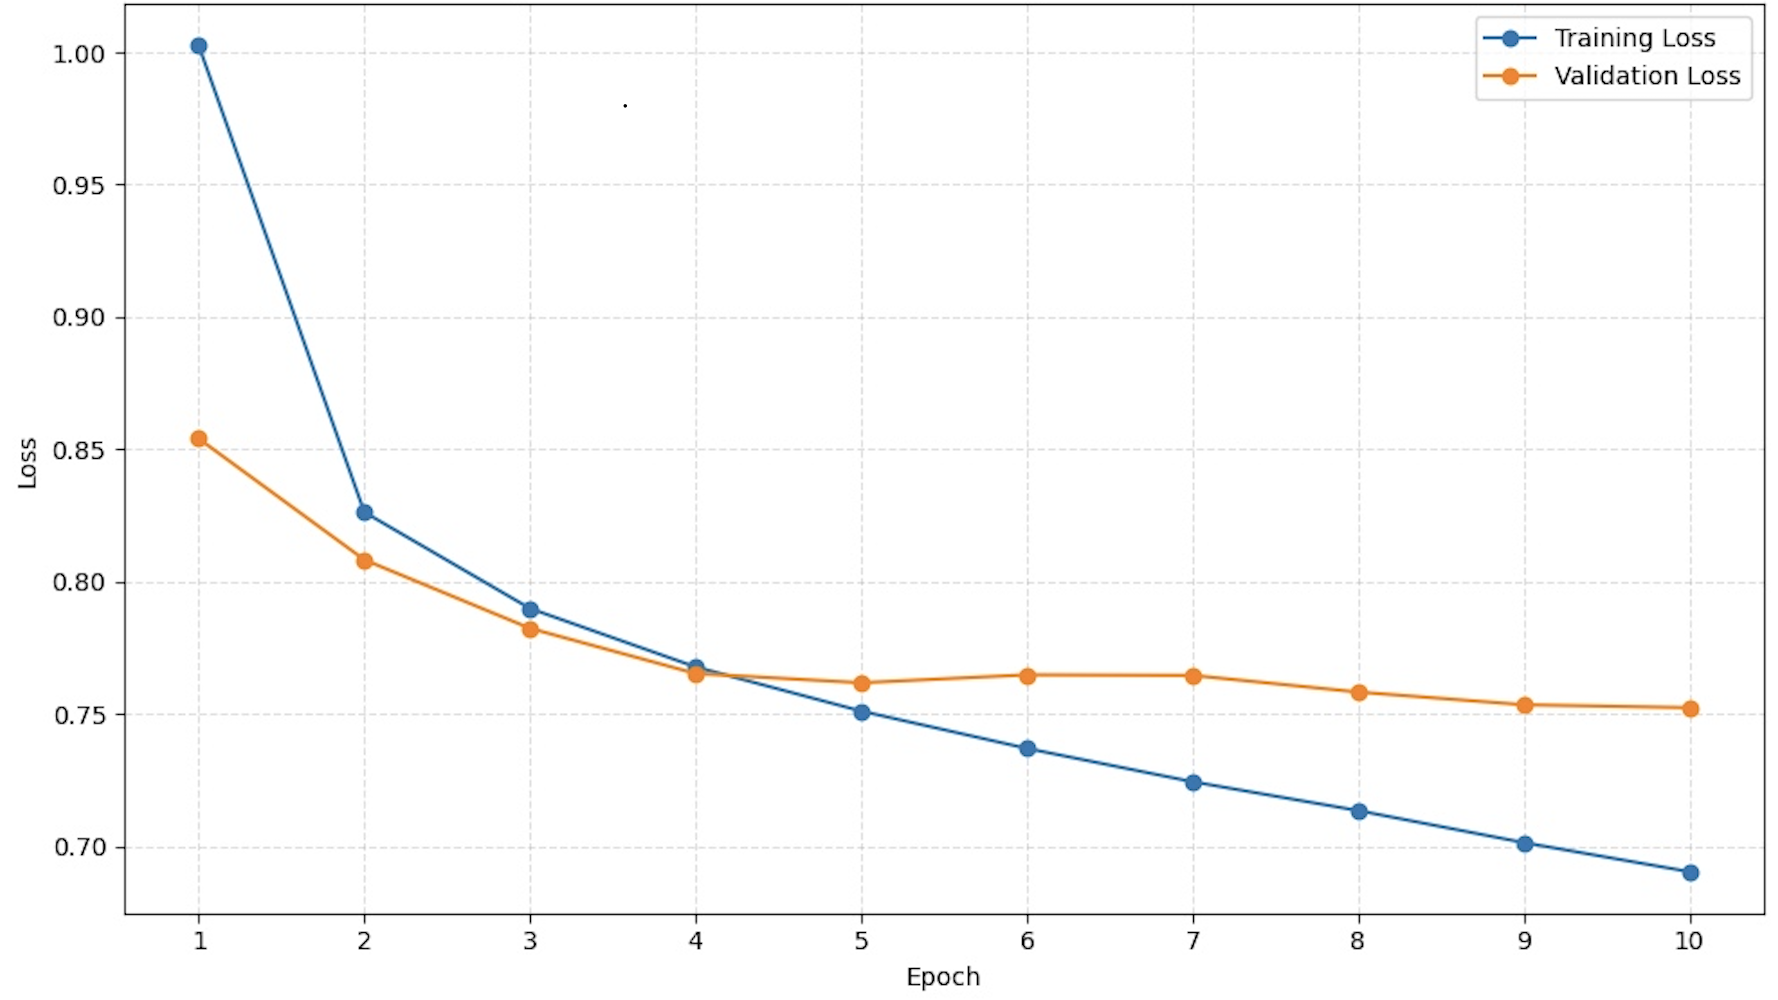

The above graph demonstrates the training vs. validation loss plot for the CNN-BiLSTM model. The model is trained using the best hyperparameter configuration obtained from the Optuna search, which includes:

1. Embedding Dimension: 64
2. Hidden Dimension: 128
3. Number of LSTM Layers: 2
4. Dropout Rate: 0.3
5. Learning Rate: 5x10^-4
6. Weight Decay: 1 x 10^-5
7. Batch Size: 32
8. CNN Output Channels: 64
9. CNN Kernel Size: 3
10. Number of CNN Layers: 1

The highest validation accuracy of 0.6541 was achieved, with a corresponding training accuracy of 0.6530.

The training and validation loss curves both decrease rapidly during the initial epochs, indicating that the convolutional layers help the model extract meaningful local features early in training. The validation curve remains close to the training curve across all epochs, showing that the model generalizes well and avoids overfitting despite the added convolutional capacity. The overall downward trend aligns closely with the training loss, confirming that the CNN-BiLSTM architecture learns stably and effectively under the chosen hyperparameters.

#### Save Best Model

In [ ]:
SAVE_PATH = "./best_cnn_lstm_yelp_model.pth"

torch.save({
    "model_state_dict": best_cnn_lstm_model.state_dict(),
    "vocab": df_train_word_to_int,                           # save vocabulary
    "tokenizer_json": df_train_tokenizer.to_str(),           # save tokenizer config
    "params": best_cnn_lstm                                  # hyperparameters
}, SAVE_PATH)

print("Model saved to:", SAVE_PATH)

#### Model Testing

###### Load the saved model

In [ ]:
checkpoint = torch.load("best_cnn_lstm_yelp_model.pth")

best_cnn_lstm_model.load_state_dict(checkpoint["model_state_dict"])
best_cnn_lstm_model.to(device)
best_cnn_lstm_model.eval()

CNNLSTMClassifier(
  (embedding): Embedding(20000, 64, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (pools): ModuleList(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

###### Model Testing

In [ ]:
test_acc_cnn_lstm, test_preds_cnn_lstm, test_labels_cnn_lstm = evaluate_on_test(best_cnn_lstm_model, best_test_loader_cnn_lstm)
print(f"Test Accuracy: {test_acc_cnn_lstm:.4f}")

Test Accuracy: 0.6667


#### Performance Metrics

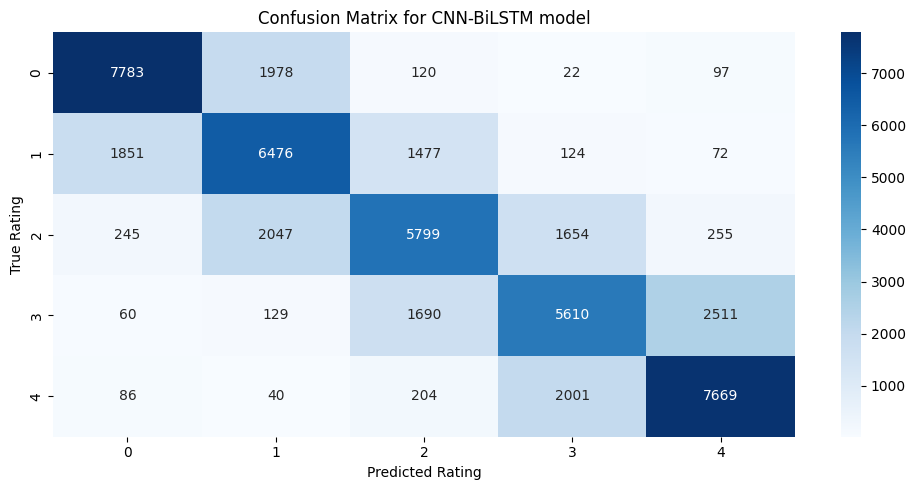

In [ ]:
# Confusion Matrix

cm_cnn_lstm = get_confusion_matrix(test_labels_cnn_lstm, test_preds_cnn_lstm)
visualize_cm(cm_cnn_lstm, "CNN-BiLSTM")

In [ ]:
# F1, Recall, Precision and Per-class Accuracy scores

counts_df = get_metric_counts_from_confusion_matrix(cm_cnn_lstm)
get_metrics_from_confusion_matrix(cm_cnn_lstm, counts_df)

,Precision,Recall,F1,Specificity,Accuracy Per Class,Support
Rating 0,0.7764,0.7783,0.7773,0.9440,0.9108,10000
Rating 1,0.6069,0.6476,0.6266,0.8952,0.8456,10000
Rating 2,0.6242,0.5799,0.6012,0.9127,0.8462,10000
Rating 3,0.5961,0.5610,0.5780,0.9050,0.8362,10000
Rating 4,0.7232,0.7669,0.7444,0.9266,0.8947,10000


###### Analysis of Misclassified Examples

In [ ]:
# ensure df_test index/reset done earlier
df_test = df_test.reset_index(drop=True)

test_preds = test_preds_cnn_lstm
test_labels = test_labels_cnn_lstm

results_df = pd.DataFrame({
    "true_label": test_labels,
    "pred_label": test_preds,
})
results_df["cleaned_text"] = df_test["cleaned_text"].values[:len(results_df)]
results_df["review_len"] = df_test["cleaned_text"].str.split().str.len().values[:len(results_df)]
results_df["error"] = results_df["pred_label"] - results_df["true_label"]
results_df["abs_error"] = results_df["error"].abs()
results_df["correct"] = results_df["error"] == 0

# Overall summary
total = len(results_df)
num_correct = results_df["correct"].sum()
num_mis = total - num_correct
print(f"Total: {total}, Correct: {num_correct}, Misclassified: {num_mis}, Accuracy={num_correct/total:.4f}")

# abs_error distribution
print("\nAbsolute error counts:")
print(results_df["abs_error"].value_counts().sort_index())

# Off-by-1 vs off-by-2+
off1 = (results_df["abs_error"] == 1).sum()
off2plus = (results_df["abs_error"] >= 2).sum()
print(f"\nOff-by-1: {off1} ({off1/num_mis:.2%} of errors), Off-by-2+: {off2plus} ({off2plus/num_mis:.2%} of errors)")

# Per-true-class miscounts and common confusions
conf = pd.crosstab(results_df["true_label"], results_df["pred_label"])
print("\nConfusion counts by true->pred (rows=true):")
print(conf)

# Length buckets
def len_bucket(n):
    if n < 60:
        return "short(<60)"
    elif n <= 200:
        return "medium(60-200)"
    else:
        return "long(>200)"

results_df["len_bucket"] = results_df["review_len"].apply(len_bucket)
bucket_summary = results_df.groupby("len_bucket")["correct"].agg(['count', lambda x: (~x).sum()])
bucket_summary.columns = ["count", "num_errors"]
bucket_summary["error_rate"] = bucket_summary["num_errors"] / bucket_summary["count"]
print("\nError rate by length bucket:")
print(bucket_summary)

# Helper to view example misclassified texts for a confusion pair
def show_examples(true_label, pred_label, n=5):
    subset = results_df[(results_df["true_label"]==true_label) & (results_df["pred_label"]==pred_label)]
    print(f"\nExamples: True {true_label} -> Pred {pred_label} (n={len(subset)})\n")
    for i, row in enumerate(subset.head(n).itertuples(), 1):
        print(f"Example {i} (len={row.review_len}):")
        print(row.cleaned_text)
        print("-"*80)

# Example pairs to inspect
show_examples(2,3, n=5)
show_examples(3,4, n=5)
show_examples(1,2, n=5)
show_examples(2,1, n=5)

Total: 50000, Correct: 33337, Misclassified: 16663, Accuracy=0.6667

Absolute error counts:
abs_error
0    33337
1    15209
2     1077
3      194
4      183
Name: count, dtype: int64

Off-by-1: 15209 (91.27% of errors), Off-by-2+: 1454 (8.73% of errors)

Confusion counts by true->pred (rows=true):
pred_label     0     1     2     3     4
true_label                              
0           7783  1978   120    22    97
1           1851  6476  1477   124    72
2            245  2047  5799  1654   255
3             60   129  1690  5610  2511
4             86    40   204  2001  7669

Error rate by length bucket:
                count  num_errors  error_rate
len_bucket                                   
long(>200)      12487        3875    0.310323
medium(60-200)  25220        8350    0.331086
short(<60)      12293        4438    0.361018

Examples: True 2 -> Pred 3 (n=1654)

Example 1 (len=19):
great barnes and noble location , and they have plenty of books that'll help you pass the time .

The CNN-BiLSTM model demonstrates comparable classification consistency compared to the BiLSTM baseline, achieving a test accuracy of 66.67%. However, systematic misclassification patterns remain, primarily concentrated between adjacent rating classes.

The majority of incorrect predictions occur between Ratings 1–2 and 3–4. Specifically, many moderately negative reviews (Rating 1) are incorrectly predicted as neutral (Rating 2), while moderately positive reviews (Rating 3) are frequently predicted as highly positive (Rating 4). This behavior indicates that the model continues to struggle with subtle variations in sentiment intensity, especially where language contains balanced or mixed opinions.

Neutral reviews (Rating 2) exhibit the most instability, often shifting toward either positive or negative classes. These errors correlate with the linguistic density of such reviews, which typically include both complimentary and critical expressions within the same text.

In contrast, highly polarized reviews (Ratings 0 and 4) show significantly lower misclassification rates, confirming that explicit sentiment language enables more reliable classification. Overall, the misclassification trend suggests that the CNN-BiLSTM architecture effectively reduces extreme classification errors but still faces limitations in distinguishing fine-grained emotional gradations in sentiment-rich but balanced reviews.

## BiLSTM and CNN-BiLSTM Model Interpretability

In [ ]:
review = "The food was terrible and overpriced."

print("Predicted Rating BiLSTM:", predict_rating(best_model, df_train_tokenizer, review, device))
print("Predicted Rating CNN-BiLSTM:", predict_rating(best_cnn_lstm_model, df_train_tokenizer, review, device))

Predicted Rating BiLSTM: 0
Predicted Rating CNN-BiLSTM: 0


In [ ]:
review = "Absolutely amazing experience! Loved the food and the staff."

print("Predicted Rating BiLSTM:", predict_rating(best_model, df_train_tokenizer, review, device))
print("Predicted Rating CNN-BiLSTM:", predict_rating(best_cnn_lstm_model, df_train_tokenizer, review, device))

Predicted Rating BiLSTM: 4
Predicted Rating CNN-BiLSTM: 4


In [ ]:
review = "The food was fine and the portions were okay, but nothing really stood out. The service wasn’t bad, but it wasn’t particularly friendly either. Overall an average experience — not great, not terrible."

print("Predicted Rating BiLSTM:", predict_rating(best_model, df_train_tokenizer, review, device))
print("Predicted Rating CNN-LSTM:", predict_rating(best_cnn_lstm_model, df_train_tokenizer, review, device))

Predicted Rating BiLSTM: 2
Predicted Rating CNN-LSTM: 2


In [ ]:
review = "The place was clean and the food tasted alright, but it didn’t really impress me. The staff did their job and the wait time was acceptable, nothing remarkable either way. I’d say it was a decent visit overall—good enough, but not something I’d go out of my way for."

print("Predicted Rating BiLSTM:", predict_rating(best_model, df_train_tokenizer, review, device))
print("Predicted Rating CNN-LSTM:", predict_rating(best_cnn_lstm_model, df_train_tokenizer, review, device))


Predicted Rating BiLSTM: 2
Predicted Rating CNN-LSTM: 1


In [ ]:
review = "Worked with this company for a small project. Communication was generally smooth, and the team delivered the work on time. The quality was good overall. Professional experience!!"

print("Predicted Rating BiLSTM:", predict_rating(best_model, df_train_tokenizer, review, device))
print("Predicted Rating CNN-LSTM:", predict_rating(best_cnn_lstm_model, df_train_tokenizer, review, device))

Predicted Rating BiLSTM: 3
Predicted Rating CNN-LSTM: 0


**BiLSTM Model Behaviour and Error Patterns**

The BiLSTM baseline is trained on tokenized, padded review sequences of length 650 using a 20k word-level vocabulary. Hyperparameter optimization with Optuna selects a two-layer bidirectional LSTM with 128-dimensional embeddings and 64 hidden units per direction, combined with dropout of 0.2 and a batch size of 64. Final training with early stopping on validation loss yields a test accuracy of 67.62% on the held-out Yelp test split of 50,000 reviews.

A detailed error analysis shows that the model’s mistakes are largely "local" in rating space. Out of 50,000 test samples, 16,470 reviews are misclassified, and about 91.5% of these errors are off by only one star. Extreme misclassifications (two or more stars away from the correct label) are relatively rare. The confusion matrix confirms that most errors occur between adjacent classes—for example, between Ratings 1 and 2, 2 and 3, and 3 and 4—while direct confusions between Rating 0 and Rating 4 are almost absent. Per-class metrics reflect the same pattern: Ratings 0 and 4, which correspond to clearly negative and clearly positive reviews, achieve the highest precision, recall, and per-class accuracy, whereas Ratings 1–3 exhibit lower recall due to shifts toward neighboring classes.

When misclassified reviews are grouped by length, longer documents show slightly higher error rates than short and medium-length reviews. Manual inspection of these long misclassified texts reveals that they often mention multiple aspects (such as food, service, and price) with mixed sentiment, for example combining positive comments on taste with complaints about wait time. In such cases, the BiLSTM sometimes focuses more heavily on a subset of the text (e.g., early praise or late criticism), predicting a rating that captures only part of the overall opinion. In contrast, reviews with very strong sentiment markers—words like "worst,"horrible" or "disgusting" for Rating 0 and "amazing," "excellent," or "best" for Rating 4—are typically recognized correctly. Overall, the BiLSTM model learns the global sentiment direction reliably but struggles to consistently distinguish between fine-grained adjacent star levels, particularly for long, mixed-sentiment reviews.

**CNN–BiLSTM Model Behaviour and Error Patterns**

The CNN–BiLSTM model augments the recurrent architecture with one or more one-dimensional convolutional layers and max-pooling before the LSTM. This design allows the network to capture local n-gram patterns and phrase-level cues (e.g., “cold food,” “super rude,” “perfect service”) before aggregating them over the full sequence with a bidirectional LSTM. Hyperparameter tuning for the configuration with sequence length 650 and 20k vocabulary identifies an effective setting with relatively compact embeddings and hidden layers and a moderate dropout rate, balancing expressiveness and regularization. On the test set, this CNN–BiLSTM variant achieves a test accuracy of 66.68%, comparable to the BiLSTM baseline.

Running the same misclassification analysis pipeline as for the BiLSTM reveals a similar but slightly more structured error profile. Misclassifications remain concentrated between neighboring rating classes, with a large fraction of errors occurring between Ratings 1 and 2 and between Ratings 3 and 4. Moderately negative reviews (true Rating 1) are frequently pushed toward the neutral class (predicted Rating 2), and moderately positive reviews (true Rating 3) are often predicted as strongly positive (Rating 4). Neutral reviews (Rating 2) are the least stable: their predictions tend to drift in both directions, reflecting the fact that these texts typically combine both compliments and complaints in the same review.

At the same time, the CNN–BiLSTM reduces the frequency of severe rating jumps compared to a purely recurrent model. The convolutional blocks help the network detect compact sentiment patterns and local contrastive phrases more reliably, which contributes to fewer extreme errors and more consistent treatment of strongly opinionated reviews. As with the BiLSTM, Ratings 0 and 4 achieve stronger precision and recall than the intermediate classes, confirming that both architectures are most confident when the sentiment is clearly expressed and lexically unambiguous. The remaining errors stem primarily from the inherent difficulty of mapping nuanced, mixed-sentiment narratives onto a discrete 0–4 star scale rather than from random model failures.

**Interpretation of BiLSTM and CNN–BiLSTM Outputs**

To qualitatively probe how the two architectures behave, several synthetic reviews were constructed, ranging from clearly negative (e.g., “The food was terrible and overpriced.”) to clearly positive (e.g., “Absolutely amazing experience! Loved the food and the staff.”) as well as longer mixed reviews that balance positive and negative aspects. For strongly negative and strongly positive examples, both the BiLSTM and the CNN–BiLSTM produce low and high ratings respectively, consistent with the overall quantitative results and with the word-level sentiment analysis from the exploratory data analysis stage. For mixed reviews that describe acceptable food but unimpressive service or vice versa, both models tend to output mid-range ratings, reflecting the ambiguity already seen in the confusion matrices and misclassification patterns.

Taken together, the BiLSTM and CNN–BiLSTM results show that both models capture the global polarity of Yelp reviews well and are robust on clearly positive or clearly negative documents. The CNN–BiLSTM adds local pattern sensitivity and reduces some extreme misclassifications, but both architectures still face challenges with borderline and neutral reviews where the sentiment signal is inherently subtle or contradictory.

## Business Insights

Since our project dataset is made up of Yelp restaurant reviews, our BiLSTM sentiment model can be meaningfully applied to food service platforms like DoorDash. DoorDash customers—especially Aggies—also leave short, medium, and even long detailed reviews after most orders, just as Yelp users do. In this project, we trained the model on cleaned, tokenized review texts using a 20k-word vocabulary, and on a testing set of 50k Yelp reviews, we obtained a 67.62% accuracy. This performance is strong enough to give DoorDash a scalable way to track sentiment at the text level, especially when paired with existing features like star ratings and operational metrics. Thus, the purpose of building the BiLSTM model is not only for academic exploration but also for extracting sentiment directly from raw review text in a practical setting.

Another important insight is that BiLSTM can handle long and descriptive reviews better than traditional bag-of-words or TF-IDF based models. Long customer reviews often have mixed emotions and signals, for example, there could be positive comments at the beginning, complaints at the end, or emotional changes throughout the text. But because BiLSTM reads the review in both forward and backward direction, it can captures contextual flow and sentiment shifts across the entire text. This creates an opportunity value for DoorDash because long reviews usually come from highly engaged customers, and converting those detailed narratives into accurate sentiment scores will give the platform a deeper understanding of customer concerns and highlight any issues that may not be interpretable from short comments or star ratings alone.

If DoorDash integrates this model into their Customer Service Portal or Insights Hub, they can unlock several real benefits. Each new review—short, medium, or long—can be converted into a 0–4 sentiment score, and importantly, the model can still infer sentiment even when customers skip the star rating or express mixed opinions. When the model predicts a low score, it could automatically flag the case so suppliers can respond to unhappy customers more quickly. Over time, aggregating predicted sentiments by store would make it possible to identify locations that underperform or detect drops in satisfaction after menu or policy updates.

When these predicted sentiment scores are combined with the factors and metrics like number of items, delivery times, and fulfilment issues, DoorDash can get a more holistic view of the customer experience. Thus, using BiLSTM model will effectively help the business convert comments and reviews into an early warning indicator, that can help business owners address the issues proactively and enhance the servie quality.